# Netzwerkanalyse mit Networkx

In diesem Notebook soll folgendes gezeigt werden:

- Was Netzwerke sind und was sich damit anfangen lässt.
- Wie ein Figurennetzwerk aus einem vorannotierten Drama erzeugt werden kann.
- Wie das Netzwerk mit zusätzlichen Informationen angereichert werden kann.
- Wie sich ein solches Netzwerk visualisieren lässt.
- Wie Zentralitätsmaße für Netzwerke funktionieren und wie sie zur Analyse eines Netzwerks genutzt werden können.
- Was "Cliquen" in Netzwerken sind und wie sie sich identifizieren lassen.



In [1]:
import collections
import re
import requests
from itertools import combinations

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx
import plotly.express as px

from scrapy.selector import Selector

## Netzwerkanalyse

Netzwerke gibt es fast überall: Verwandtschaften, Freundes- und Bekanntenkreise, Rechnernetze, das WWW, soziale Netzwerke (z.B. Instagram oder Twitter), biologische Netzwerke (z.B. zur Analyse der Zusammenhänge zwischen einzelnen Genen oder der Interaktionen verschiedener physiologischer Systeme), Verkehrsnetze usw. usf.

Solche Netzwerke lassen sich als Graphen darstellen und mithilfe der (mathematisch-informatischen) [Graphentheorie](https://de.wikipedia.org/wiki/Graphentheorie) beschreiben und analysieren: Was sind etwa die zentralen Knoten (Akteure) in einem sozialen Netzwerk? Was sind interessante Teilnetzwerke? Über wie viele Ecken sind zwei Personen miteinander verbunden (was ist der kürzeste Pfad zwischen zwei Knoten)?

Ein Graph besteht aus einer Menge von Knoten (*nodes* oder *vertices*) und Kanten (*edges*). Eine Kante verbindet stets genau zwei Knoten, die damit als *benachbart* oder *adjazent* gelten. Man kann einen Graphen alternativ auch als Nachbarschaftsmatrix oder Adjazenzmatrix darstellen, also als Matrix, die Informationen darüber enthält, welche Knoten direkt miteinander verbunden sind und welche nicht. Dazu später mehr.

Ein einfacher Graph kann z.B. so aussehen (die Verbindungslängen sind irrelevant):

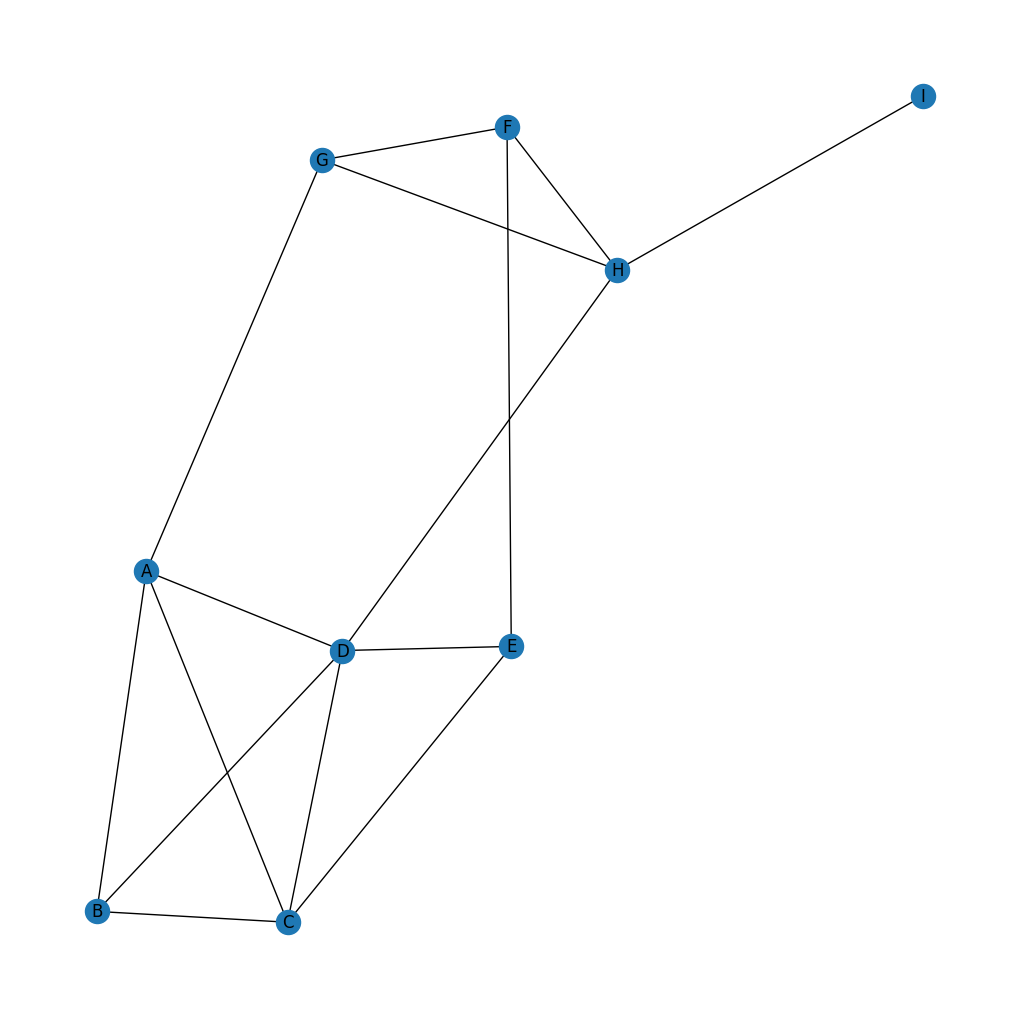

In [2]:
G = nx.Graph()
G.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])
G.add_edges_from([('A', 'B'), ('B', 'C'), ('A', 'C'), ('C', 'D'), ('D', 'A'),
                  ('D', 'B'), ('D', 'E'), ('E', 'F'), ('F', 'G'), ('G', 'H'),
                  ('H', 'I'), ('H', 'F'), ('E', 'C'), ('A', 'G'), ('H', 'D')])

plt.rcParams["figure.figsize"]=10,10
nx.draw(G, with_labels=True) # wenn das hier einen Fehler produziert, bitte das Paket "decorator" aktualisieren
plt.show()

Wenn die Kanten eines Graphen *gerichtet* sind, wenn es also eine Rolle spielt, von welchem Knoten eine Verbindung zu einem anderen ausgeht (und nicht bloß, *dass* es eine Verbindung gibt), spricht man von einem *gerichteten Graphen* oder *Digraphen* (von *directed graph*):

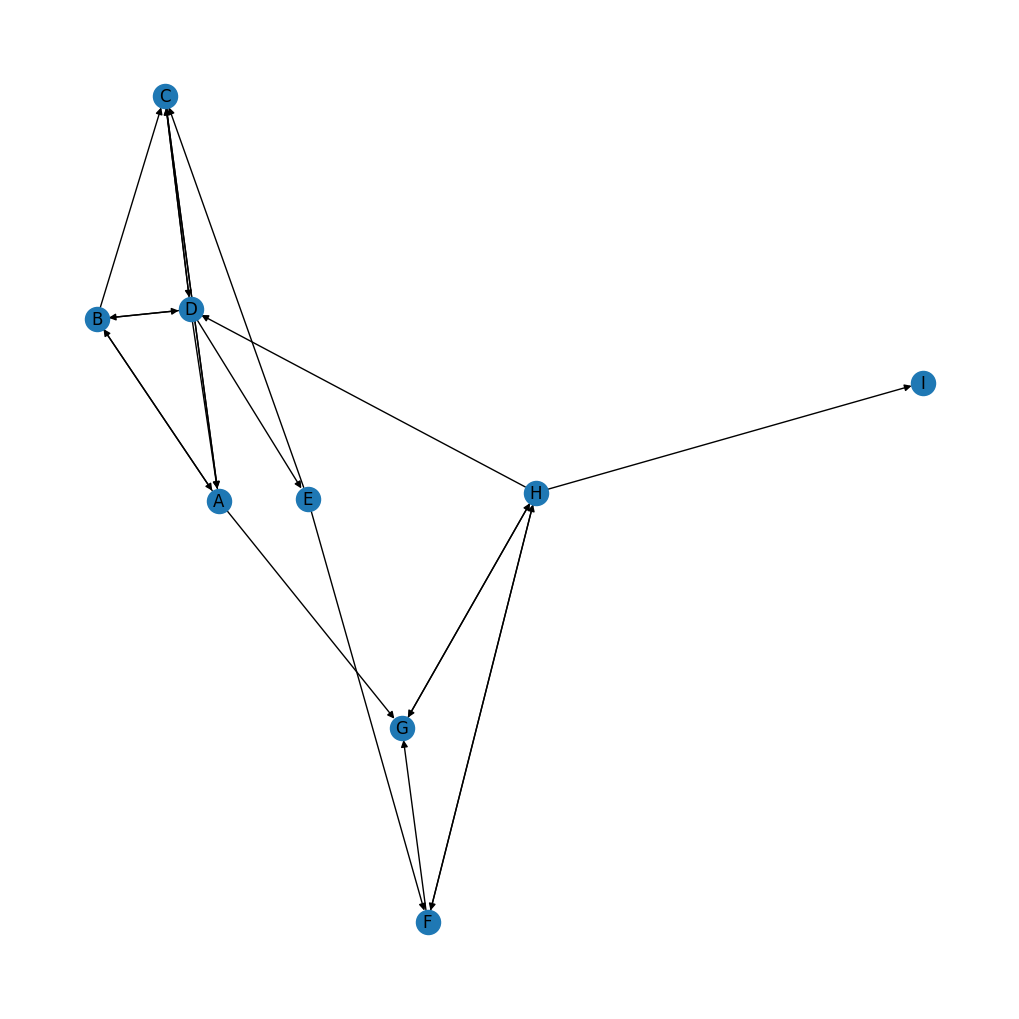

In [3]:
G = nx.DiGraph()

G.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])
G.add_edges_from([('A', 'B'), ('B', 'A'), ('B', 'C'), ('A', 'C'), ('C', 'A'),
                  ('C', 'D'), ('D', 'A'), ('D', 'C'), ('D', 'B'), ('B', 'D'),
                  ('D', 'E'), ('E', 'F'), ('F', 'G'), ('G', 'H'), ('H', 'G'),
                  ('H', 'I'), ('H', 'F'), ('F', 'H'), ('E', 'C'), ('A', 'G'),
                  ('H', 'D')])

plt.rcParams["figure.figsize"]=10,10
nx.draw(G, with_labels=True)
plt.show()

Sind mehrere Kanten zwischen zwei Knoten möglich, hat man es mit einem *Multigraphen* zu tun. Anstelle nun aber beispielsweise jede Interaktion zwischen zwei Personen (Knoten) mit einer eigenen Kante zu modellieren, kann man Kanten auch (numerische) *Gewichte* geben – in diesem Falle also etwa die Anzahl von Interaktionen. Dies beeinflusst z.B. die Berechnung von Zentralitätsmaßen.

Wichtig für die Modellierung eines konkreten Netzwerks sind u.a. folgende Fragen:

- Was sollen Knoten und Kanten des Netzwerks sein? Grundsätzlich lässt sich alles zu Knoten und Kanten erklären – nicht immer ist die offensichtliche Modellierung auch die beste oder informativste.
- Soll das Netzwerk gerichtet oder ungerichtet sein?
- Kann es mehr als eine Kante zwischen zwei Knoten geben (z.B. Verbindungen unterschiedlicher Art)?
- Gibt es nur Knoten einer einzigen Art, oder kommen verschiedene Knotenarten vor (z.B. Personen und Orte)? (Hat man es mit zwei Mengen von Knoten zu tun, wobei jeder Knoten nur mit Knoten der anderen Menge verbunden ist, spricht man von einem *bipartiten Graphen*.)
- Sollen die Kanten Gewichte haben? Wenn ja, welche?
- Wann gibt es überhaupt eine Verbindung/Kante zwischen zwei Knoten?

Eine ausführlichere Einführung in die Netzwerkanalyse gibt es z.B. in Kapitel 10 von [Jannidis et al. (2017)](https://link.springer.com/book/10.1007%2F978-3-476-05446-3). Einen [DataCamp-Kurs zur Einführung](https://campus.datacamp.com/courses/introduction-to-network-analysis-in-python/) gibt es auch.

## Textauswahl
Wir nutzen hier das [German Drama Corpus](https://dracor.org/ger) und verwenden dabei die [TEI-Version der Texte](https://dracor.org/api/corpora/ger/play/goethe-faust-eine-tragoedie/tei), die genauer annotiert sind. Das erlaubt uns, uns genau die Elemente herauszupicken, die uns interessieren.

Als Beispieltext nehmen wir Goethes *Faust* – das Vergnügen dürften ja viele gehabt haben, sodass es vielleicht leichter fällt, das Netzwerk auf Plausibilität zu prüfen.

Die Webseite erhalten wir am einfachsten mit dem `requests`-Modul (da wir nur eine Seite wollen, brauchen wir dafür ja nicht unbedingt eine eigene Scrapy-Spider). Weil wir schon Erfahrung mit Scrapy und XPath haben, machen wir mit einem `Selector` weiter.

In [4]:
page = requests.get('https://dracor.org/api/corpora/ger/play/goethe-faust-eine-tragoedie/tei')
response = Selector(text=page.content, type='xml')
response.remove_namespaces() # sonst klappt der Zugriff auf die einzelnen Elemente nicht

## Vorverarbeitung: Sprecherdaten

Nachdem wir nun einen `Selector` haben, können wir uns Elemente herauspicken, die uns interessieren, z.B. die Personenübersicht samt Geschlechtsangaben:

In [5]:
personen = response.xpath('//person/@id | //personGrp/@id').getall() # personGrp ("Rufe" etc.) könnte man natürlich auch bewusst ignorieren
geschlecht = response.xpath('//person/@sex  | //personGrp/@sex').getall()
person_geschlecht = dict(zip(personen, geschlecht))
person_geschlecht

{'direktor': 'MALE',
 'dichter': 'MALE',
 'lustige_person': 'MALE',
 'raphael': 'MALE',
 'gabriel': 'MALE',
 'michael': 'MALE',
 'mephistopheles': 'MALE',
 'der_herr': 'MALE',
 'faust': 'MALE',
 'geist': 'UNKNOWN',
 'wagner': 'MALE',
 'chor_der_engel': 'UNKNOWN',
 'chor_der_weiber': 'FEMALE',
 'chor_der_juenger': 'MALE',
 'einige_handwerksburschen': 'MALE',
 'andre_handwerksburschen': 'MALE',
 'ein_handwerksbursch': 'MALE',
 'zweiter_handwerksbursch': 'MALE',
 'ein_dritter_handwerksbursch': 'MALE',
 'vierter_handwerksbursch': 'MALE',
 'fuenfter_handwerksbursch': 'MALE',
 'erstes_dienstmaedchen': 'FEMALE',
 'andres_dienstmaedchen': 'FEMALE',
 'erster_schueler': 'MALE',
 'buergermaedchen': 'FEMALE',
 'zweiter_schueler': 'MALE',
 'buerger': 'MALE',
 'bettler': 'MALE',
 'andrer_buerger': 'MALE',
 'dritter_buerger': 'MALE',
 'alte': 'FEMALE',
 'die_andre': 'FEMALE',
 'soldaten': 'MALE',
 'bauern_unter_der_linde': 'UNKNOWN',
 'alter_bauer': 'MALE',
 'alle_vor_dem_tor': 'UNKNOWN',
 'geister':

Warum da nun z.B. die Hexen ein unbekanntes Geschlecht haben, müsste man die Annotatoren fragen ...

Im TEI-Dokument befinden sich Szenen in `<div>`-Tags mit dem Attribut `type="scene"`. Dialogbeiträge einzelner Sprecher sind in `<sp>`-Tags, das Attribut `who` verweist auf die einzelnen Sprecher aus der Liste von eben (mit `#` davor).
Etwas problematisch ist, dass in einem `who`-Attribut mitunter auch mehrere Sprecher enthalten sein können, falls sie zusammen sprechen oder singen.

Innerhalb von `<sp>` gibt es `<p>`-Tags für die eigentliche Rede, wobei Bühnenanweisungen noch einmal mit `<stage>` markiert sind. Wenn wir also den Text direkt unterhalb von `<p>` extrahieren, schließt das die Bühnenanweisungen aus – wunderbar!

Die Liste der Sprecher bekommen wir z.B. so:

In [6]:
alle_sprecher = response.xpath('//sp/@who').getall()
alle_sprecher = [s.replace('#', '') for s in alle_sprecher] # Gartenzäune vor den Sprechernamen entfernen
alle_sprecher = [s.split() for s in alle_sprecher] # wenn mehrere Sprecher in einem String sind, auftrennen
alle_sprecher = [item for sublist in alle_sprecher for item in sublist] # Liste von Listen (z.B. [['a'], ['b', 'c'], ['d']]) wieder zu einer flachen Liste machen (also ['a', 'b', 'c', 'd'])
alle_sprecher[0:10] # die ersten 10

['direktor',
 'dichter',
 'lustige_person',
 'direktor',
 'dichter',
 'direktor',
 'dichter',
 'lustige_person',
 'dichter',
 'lustige_person']

Wenn uns interessiert, wie oft jeder Sprecher irgendetwas sagt, können wir das z.B. mit `collections.Counter()` oder mit `value_counts()` (bei einer `Series`) ermitteln:

In [7]:
sprechfrequenzen = pd.Series(alle_sprecher).value_counts(ascending=False)
sprechfrequenzen
# alternativ:
# dict(collections.Counter(alle_sprecher))

mephistopheles     257
faust              224
gretchen            96
marthe              40
frosch              29
                  ... 
hexenmeister         1
stimme_5             1
stimme_4             1
stimme_3             1
stimme_von_oben      1
Length: 115, dtype: int64

Etwas schwieriger wird es, wenn wir stattdessen die Dialogmenge haben möchten. Ordnen wir zuerst einmal den Dialog den Sprechern zu:

In [8]:
daten = []
for sp in response.xpath('//sp'):
    sprecher = sp.xpath('./@who').get()
    sprecher = sprecher.replace('#', '')
    text = sp.xpath('.//p//text() | .//l//text()').getall() # Text unterhalb von <p> oder von <l> (Liedzeilen)
    text = ' '.join(text).strip() # Textnodes verbinden
    text = re.sub(r'^\s+', '', text, flags=re.MULTILINE) # Whitespaces am Zeilenanfang entfernen
    text = re.sub(r"[^\S\n]+", " ", text) # überflüssige Whitespaces innerhalb des Textes entfernen
    # falls mehrere Sprecher in einem String, für jeden davon:
    for s in sprecher.split():
        daten.append([s, text])

dialog = pd.DataFrame(daten, columns = ['sprecher', 'text'])
dialog

sprecher                                               text
0           direktor  Ihr beiden, die ihr mir so oft, In Not und Trü...
1            dichter  O sprich mir nicht von jener bunten Menge, Bei...
2     lustige_person  Wenn ich nur nichts von Nachwelt hören sollte....
3           direktor  Besonders aber laßt genug geschehn! Man kommt ...
4            dichter  Ihr fühlet nicht, wie schlecht ein solches Han...
..               ...                                                ...
949         gretchen  Dein bin ich, Vater! Rette mich! Ihr Engel! Ih...
950   mephistopheles                                 Sie ist gerichtet!
951  stimme_von_oben                                      Ist gerettet!
952   mephistopheles                                        Her zu mir!
953         gretchen                                Heinrich! Heinrich!

[954 rows x 2 columns]

Fügen wir eine neue Spalte mit der jeweiligen Textlänge in Zeichen an. Schöner wäre es natürlich, die Wörter nach einer ordentlichen Tokenisierung zu zählen, aber ich erwarte hier keinen großen Einfluss auf die Auswertung. Ihr könnt das gerne entsprechend anpassen, wenn ihr möchtet!

In [9]:
dialog['laenge'] = dialog['text'].str.len()
dialog

sprecher                                               text  \
0           direktor  Ihr beiden, die ihr mir so oft, In Not und Trü...   
1            dichter  O sprich mir nicht von jener bunten Menge, Bei...   
2     lustige_person  Wenn ich nur nichts von Nachwelt hören sollte....   
3           direktor  Besonders aber laßt genug geschehn! Man kommt ...   
4            dichter  Ihr fühlet nicht, wie schlecht ein solches Han...   
..               ...                                                ...   
949         gretchen  Dein bin ich, Vater! Rette mich! Ihr Engel! Ih...   
950   mephistopheles                                 Sie ist gerichtet!   
951  stimme_von_oben                                      Ist gerettet!   
952   mephistopheles                                        Her zu mir!   
953         gretchen                                Heinrich! Heinrich!   

     laenge  
0      1048  
1       674  
2       568  
3       643  
4       158  
..      ...  
949     133  
950      18  
951      13  
952      11  
953      19  

[954 rows x 3 columns]

Daraus können wir nun leicht bestimmen, wie viel jeder einzelne Sprecher von sich gibt:

In [10]:
textlaenge = dialog.groupby(['sprecher'])['laenge'].sum() # Pandas: Gruppiere nach Sprecher, nimm die Spalte 'laenge' und bilde jeweils (also für jeden Sprecher) die Summe der Werte aus der Spalte
textlaenge.sort_values(ascending=False)
# Die Sprechfrequenzen könnten wir nun natürlich auch anhand der Tabelle berechnen:
# sprechfrequenzen = dict(dialog['sprecher'].value_counts())

sprecher
faust                          49726
mephistopheles                 45977
gretchen                       14864
wagner                          4340
direktor                        3751
                               ...  
stimme_8                          33
stimme_2                          26
ein_dritter_handwerksbursch       24
stimme_von_oben                   13
stimme_7                          13
Name: laenge, Length: 115, dtype: int64

## Vorverarbeitung: Verbindungen

Hier basteln wir uns nun endlich die Verbindungsstärken zwischen den beteiligten Charakteren.

Um die Interaktionshäufigkeiten oder die Beziehungsstärke zwischen Charakteren zu messen, gibt es verschiedene Möglichkeiten. Präsentiert man später Ergebnisse einer Netzwerkanalyse, ist es in jedem Falle wichtig, die verwendete Methode anzugeben, da sich die ermittelten Netzwerke je nach Methode durchaus unterscheiden können.

Eine Variante (die sich v.a. für erzählende Literatur eignet) wäre, nach Figurennamen zu suchen, um dann für jeden Fund in einem festgelegten Umkreis nach weiteren Namen zu suchen (das ist im Prinzip die Kookkurrenzmethode, die auch in der Korpuslinguistik verwendet wird, um Kollokationskandidaten zu finden). Findet man einen Namen im Umkreis, wird die Interaktionshäufigkeit für diese beiden Charaktere um eins erhöht. Will man vermeiden, dass dieselbe Textstelle ein zweites Mal gezählt wird, wenn man vom zweiten Namen aus die Fundstellenumkreise durchgeht, könnte man für jede Interaktion die Textstelle als ungeordnete Menge aus zwei Elementen (Position des ersten Wortes, Position des zweiten Wortes) festhalten, um Dopplungen zu vermeiden.

In einem Drama mit kurzen Szenen wäre es auch möglich, einfach jede Szene, in der Charaktere gemeinsam auftreten, als Interaktion zu werten. Das wäre eine recht grobe Methode, weil Charaktere natürlich auch innerhalb einer Szene häufiger oder weniger häufig miteinander interagieren können – oder auch überhaupt nicht. Bei [DraCor](https://dracor.org/ger/goethe-faust-eine-tragoedie) scheint man dennoch so vorgegangen zu sein. In einem Roman bspw. könnte man diese Methode auch auf andere Texteinheiten, z.B. Kapitel oder Abschnitte, anwenden.

Da sich in einem Drama immer Sprecher abwechseln und alle Sprecher annotiert sind, können wir auch einfach die Liste der Sprecher extrahieren und dann gucken, welche aufeinanderfolgenden Sprecher in welchen Häufigkeiten in dieser Liste auftauchen. Beachten müssen wir dabei aber, dass wir so Erwähnungen anderer Charaktere in der wörtlichen Rede oder in den Bühnenanweisungen nicht erfassen. Aus den Bühnenanweisungen könnte grundsätzlich auch hervorgehen, dass ein Charakter von der Bühne abtritt – wenn dann direkt nach dessen letzter Äußerung ein anderer Charakter etwas sagt, dann ist das natürlich eigentlich keine Interaktion. Auch kann es sein, dass wir auf diese Weise bestimmte Arten von Interaktionen (z.B. indirekte) gar nicht erfassen, weil Charaktere nicht direkt nacheinander sprechen.

Eine ideale Lösung gibt es wahrscheinlich nicht – für jede Untersuchung sollte sorgfältig zwischen den Vor- und Nachteilen verschiedener Ansätze abgewogen werden.

Wir entscheiden uns hier für die letzte Möglichkeit (die zweite wurde ja bereits von DraCor umgesetzt).

In [11]:
def sort_tuple_list(input_list):
    """
    Hilfsfunktion, um Tupel in Listen alphabetisch zu sortieren, sodass
    z.B. ('krawutschke', 'lehmann') zu ('lehmann', 'krawutschke') wird.
    """
    return [tuple(sorted(i)) for i in input_list]


def get_interactions(input_list):
    """
    Funktion zur Ermittlung direkter Charakterinteraktionen aus einer
    Charakterliste.
    """
    bigrams = []
    # Gehe die Elemente der Liste durch:
    for i in range(len(input_list)-1):
        combis = []
        # Nimm das aktuelle Listenelement und das darauffolgende, trenne
        # beide Elemente an Leerzeichen in Listen auf:
        l1 = sorted(input_list[i].split())
        l2 = sorted(input_list[i+1].split())
        # Wenn mehrere Charaktere in einem String sind, wollen wir einmalig(!)
        # eine Interaktion zwischen jedem Paar von Charakteren festhalten
        # (gemeinsames Sprechen ist ja auch eine Art der Interaktion).
        # Da wir fast alle Strings zweimal betrachten (einmal als ersten Teil
        # eines Bigramms, einmal als zweiten), macht das den Code der ganzen
        # Funktion etwas umständlicher.
        if i == 0 and len(l1) > 1:
            for combi in combinations(l1, 2):
                combis.append(combi)
        if len(l2) > 1:
            for combi in combinations(l2, 2):
                combis.append(combi)
        # Nur wenn l1 und l2 nicht identisch sind, wollen wir (weitere)
        # Interaktionen festhalten:
        if l1 != l2:
            # Gehe die Elemente von l1 und l2 durch und ermittle Kombinationen
            # nicht-identischer Elemente:
            for e1 in l1:
                for e2 in l2:
                    if e1 != e2:
                        combis.append((e1, e2))
        # Füge jede gefundene Kombination nur ein einziges Mal der Bigrammliste
        # hinzu:
        for combi in set(sort_tuple_list(combis)):
            bigrams.append(combi)
    return bigrams

Um Szenengrenzen zu berücksichtigen, erstellen wir unsere Sprecher-Bigramme pro Szene – denn ein Charakter ganz am Ende einer Szene interagiert ja nicht unbedingt mit dem Charakter ganz am Anfang der nächsten! (Aber Achtung: Nicht in allen Stücken gibt es im TEI-Markup eine durchgängige Szenengliederung. Zum Teil kommen Dialoge auch direkt unterhalb von `<div type="prologue">` o.ä. vor.)

Wir berechnen außerdem gleich die Häufigkeiten der Bigramme. Weil diese Häufigkeiten sich schlecht direkt graphisch darstellen lassen (weil es für wenige Paare sehr hohe Interaktionshäufigkeiten gibt, für andere aber sehr niedrige), müssen wir uns überlegen, wie wir damit umgehen.

Eine Möglichkeit wäre, die Daten zu transformieren, indem wir zusätzlich den natürlichen Logarithmus als `weight` berechnen (allerdings mit `np.log1p()`, also indem wir vorher 1 zur Häufigkeit addieren – denn der Logarithmus von 1 ist 0). Diese logarithmierten Häufigkeiten könnten wir dann in der graphischen Darstellung des Figurennetzwerks als Kantenstärken verwenden. Auch andere Transformationen wie die Quadratwurzel kämen in Frage – ein Problem damit ist bloß die (intuitive) Vergleichbarkeit der Werte.

Wir nehmen daher einfach die relativen Häufigkeiten der Bigramme (in Prozent) als `weight` für die Kantenstärken (alternativ könnte man darüber z.B. auch die Transparenz oder die Farbe der Verbindungen festlegen). Damit sind alle Werte in einem vorher definierten Bereich, wenngleich natürlich viele Verbindungen sehr dünn werden dürften.

In [12]:
bigrams = []
for scene in response.xpath('//div[@type = "scene"]'):
    sprecher = scene.xpath('.//sp/@who').getall()
    sprecher = [s.replace('#', '') for s in sprecher]
    bigrams += get_interactions(sprecher)

c = collections.Counter(bigrams) # Tupelhäufigkeiten

df = pd.DataFrame(c.keys(), columns = ['from', 'to'])
df['frequency'] = c.values()
# df['weight'] = [np.log1p(value) for value in c.values()] # für logarithmierte Häufigkeiten
df['weight'] = df['frequency'] / df['frequency'].sum() * 100 # für relative Häufigkeiten
df

from               to  frequency    weight
0           dichter         direktor          4  0.415369
1           dichter   lustige_person          4  0.415369
2          direktor   lustige_person          2  0.207684
3           gabriel          raphael          2  0.207684
4           gabriel          michael          2  0.207684
..              ...              ...        ...       ...
152      irrlichter    sternschnuppe          1  0.103842
153    die_massiven    sternschnuppe          1  0.103842
154    die_massiven             puck          1  0.103842
155           ariel        orchester          1  0.103842
156  mephistopheles  stimme_von_oben          2  0.207684

[157 rows x 4 columns]

## Erstellung des Netzwerks

Aus der Tabelle können wir nun mit `networkx` das Netzwerk erstellen ([das geht natürlich nicht nur aus Tabellen](https://networkx.github.io/documentation/stable/reference/convert.html)). Auch wenn wir die Spalten hier `from` und `to` genannt haben, handelt es sich dabei um ein *ungerichtetes Netzwerk*, bei dem für jede Verbindung zwischen zwei Knoten nur relevant ist, dass sie existiert. Bei einem *gerichteten Netzwerk* wäre dagegen wichtig, von welchem Knoten eine ausgeht und zu welchem Knoten sie führt. Das könnte man sich z.B. bei einem Twitter-Netzwerk gut vorstellen, wo einzelne Benutzer anderen folgen können, diese dadurch aber nicht automatisch "zurückfolgen" – die Richtung ist dort also relevant. Bei Figurennetzwerken könnte man gerichtete Graphen z.B. verwenden, um damit Erwähnungen von Charakteren in der Rede anderer Charaktere abzubilden. Die Interaktionen, mit denen wir uns hier beschäftigen, sind aber konzeptionell sicherlich beidseitig, also ungerichtet.

In [13]:
E = nx.from_pandas_edgelist(df, 'from', 'to', ['frequency', 'weight'])

Mit der Liste `['frequency', 'weight']` haben wir dem Netzwerk bereits zwei Kantenattribute übergeben. Auch die Knoten/Nodes eines Graphen können Attribute haben, und Attribute lassen sich den Kanten und Knoten grundsätzlich jederzeit hinzufügen.

Wir greifen nun auf unsere vorhin erstellten Dictionaries `person_geschlecht`, `sprechfrequenzen` und `textlaenge` zurück, um den einzelnen Knoten Eigenschaften zuzuweisen. Für Sprechfrequenzen und Textlängen – die wir bei der Visualisierung des Netzwerks potentiell für die Größe der Knoten heranziehen wollen – berechnen wir jeweils den Anteil an den Gesamtmengen und multiplizieren ihn mit einer Konstante, die für brauchbare Knotengrößen sorgt.

In [14]:
textlaengensumme = sum(textlaenge)
sprechfrequenzensumme = sum(sprechfrequenzen)

for node in E.nodes():
    if node in person_geschlecht:
        E.nodes[node]['sex'] = person_geschlecht[node]
    else:
        E.nodes[node]['sex'] = 'UNKNOWN'
    E.nodes[node]['sprechfrequenz'] = sprechfrequenzen[node]
    E.nodes[node]['sprechfrequenz_weight'] = sprechfrequenzen[node] / sprechfrequenzensumme * 2000
    E.nodes[node]['textlaenge'] = textlaenge[node]
    E.nodes[node]['text_weight'] = textlaenge[node] / textlaengensumme * 2000 # Konstante so wählen, dass die Kreise in den späteren Plots eine sinnvolle Größe erhalten

So sehen unsere Nodes nun aus (`data=True` sorgt jeweils dafür, dass auch die Attribute zurückgegeben werden):

In [15]:
list(E.nodes(data=True))[0:5] # nur die ersten 5

[('dichter',
  {'sex': 'MALE',
   'sprechfrequenz': 4,
   'sprechfrequenz_weight': 8.385744234800839,
   'textlaenge': 2275,
   'text_weight': 27.549543767445524}),
 ('direktor',
  {'sex': 'MALE',
   'sprechfrequenz': 4,
   'sprechfrequenz_weight': 8.385744234800839,
   'textlaenge': 3751,
   'text_weight': 45.42344556997281}),
 ('lustige_person',
  {'sex': 'MALE',
   'sprechfrequenz': 3,
   'sprechfrequenz_weight': 6.289308176100629,
   'textlaenge': 2269,
   'text_weight': 27.476885630036872}),
 ('gabriel',
  {'sex': 'MALE',
   'sprechfrequenz': 2,
   'sprechfrequenz_weight': 4.1928721174004195,
   'textlaenge': 396,
   'text_weight': 4.795437068970736}),
 ('raphael',
  {'sex': 'MALE',
   'sprechfrequenz': 2,
   'sprechfrequenz_weight': 4.1928721174004195,
   'textlaenge': 375,
   'text_weight': 4.541133588040471})]

Und so die Kanten:

In [16]:
list(E.edges(data=True))[0:5]

[('dichter', 'direktor', {'frequency': 4, 'weight': 0.4153686396677051}),
 ('dichter', 'lustige_person', {'frequency': 4, 'weight': 0.4153686396677051}),
 ('direktor',
  'lustige_person',
  {'frequency': 2, 'weight': 0.20768431983385255}),
 ('gabriel', 'raphael', {'frequency': 2, 'weight': 0.20768431983385255}),
 ('gabriel', 'michael', {'frequency': 2, 'weight': 0.20768431983385255})]

## Visualisierung
networkx ist primär zur Erstellung und Analyse von Netzwerken da, nicht zur Visualisierung – vielleicht fallen diese Funktionen in Zukunft sogar weg. Schönere (und z.T. interaktive) Visualisierungen erhält man mit einer Vielzahl anderer Tools, z.B. Gephi, GraphViz oder Cytoscape. networkx kann Graphen [in verschiedenen Formaten exportieren](https://networkx.github.io/documentation/stable/reference/readwrite/index.html), sodass man sie leicht mit solchen Tools darstellen kann.

Dennoch können wir unseren Graphen natürlich auch erst einmal mit networkx visualisieren. Als klassisches Netzwerk sieht das womöglich etwas unübersichtlich aus. Wir fangen trotzdem damit an.

Wir zeichnen hier Knoten (*nodes*), Knotenbezeichnungen (*labels*) und Kanten (*edges*) separat (statt einfach `nx.draw()` zu verwenden), weil wir so z.B. die Transparenz gezielter steuern können.

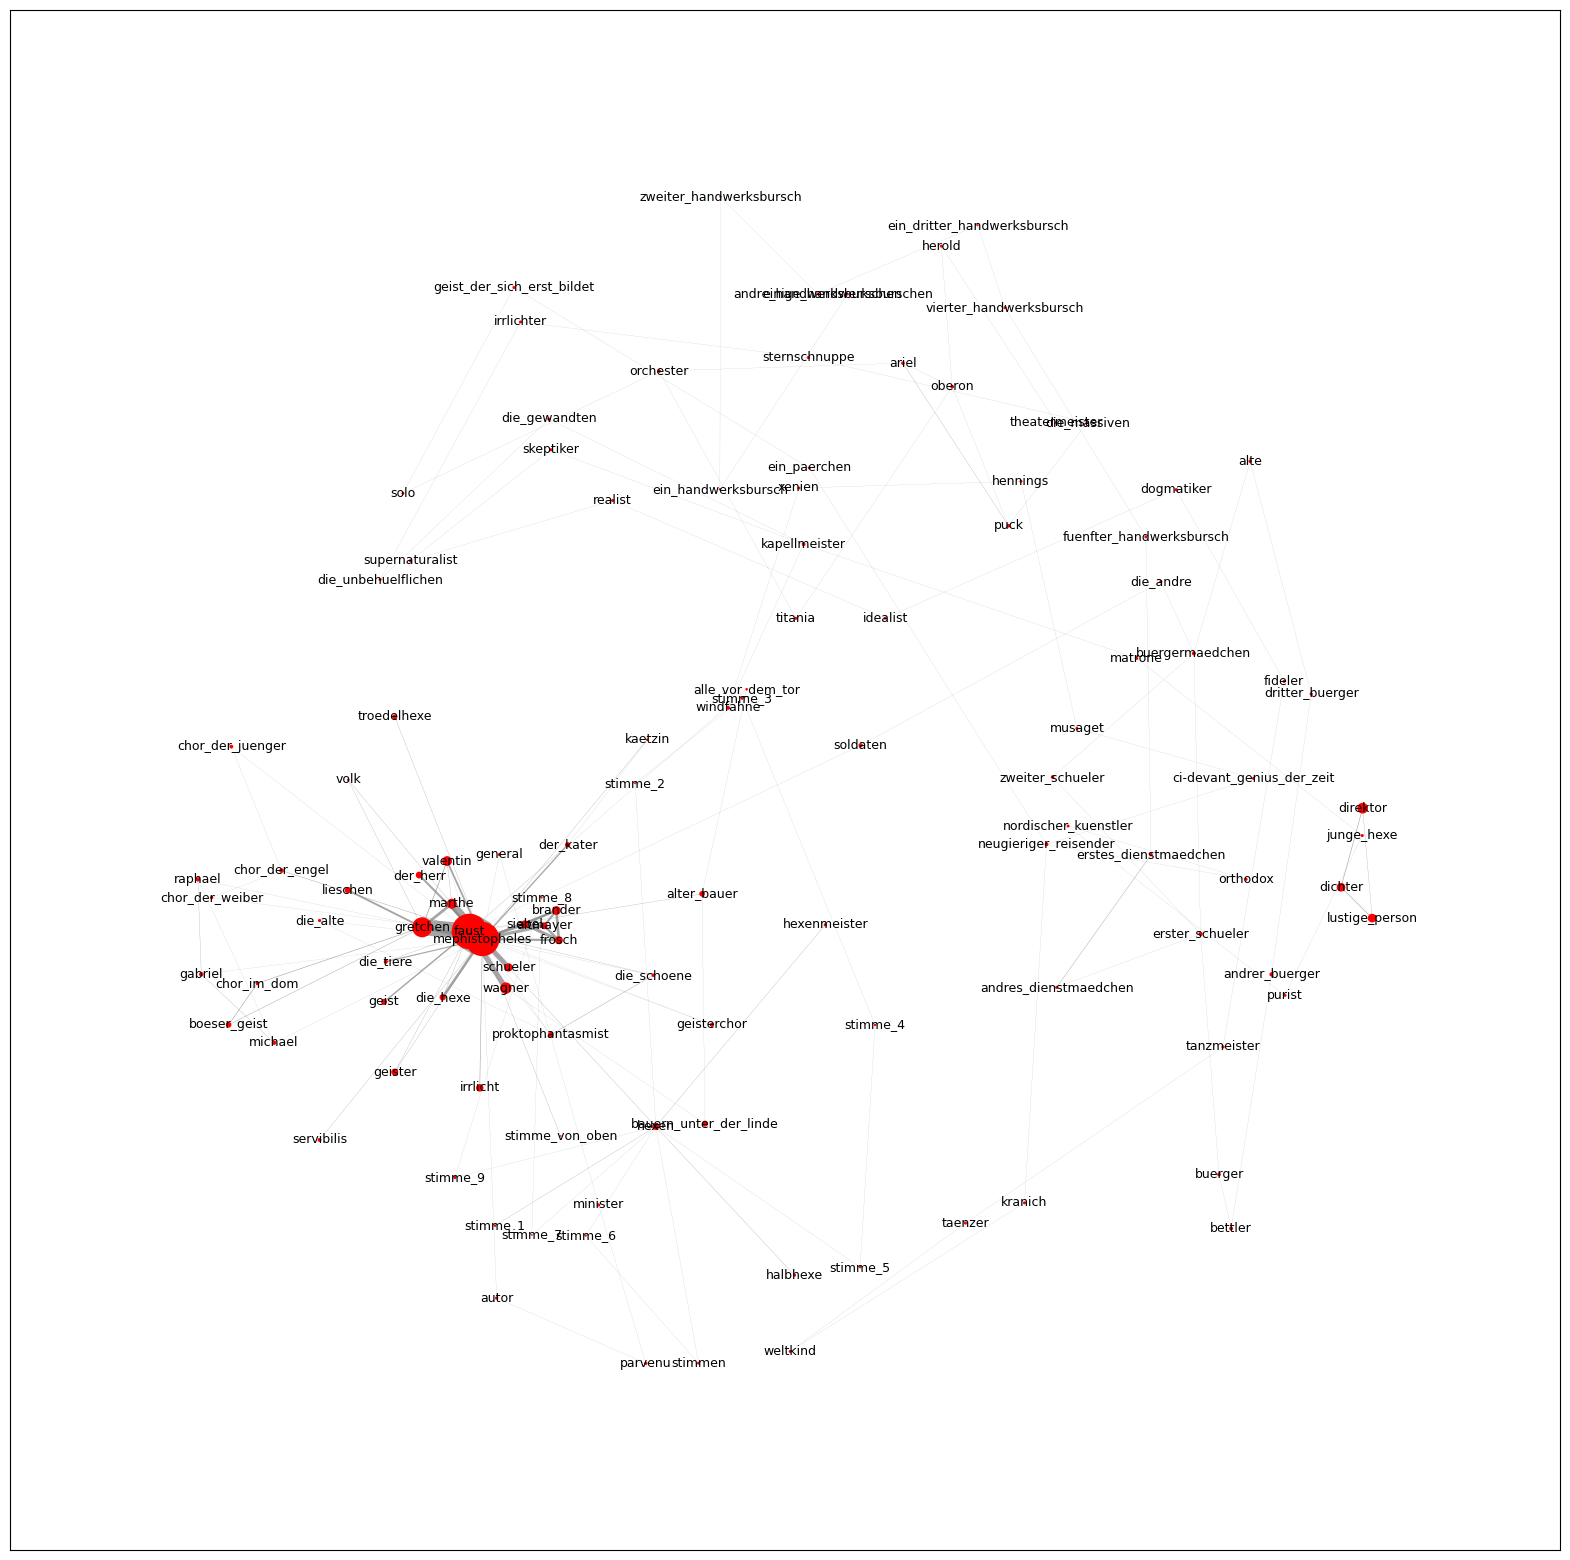

In [17]:
plt.rcParams["figure.figsize"]=20,20

pos = nx.spring_layout(E, k=.2) # mit k lässt sich der Abstand zwischen Nodes regulieren
nx.draw_networkx_nodes(E,
                       pos=pos,
                       node_color='red',
                       node_size=list(nx.get_node_attributes(E, 'text_weight').values())
                      )
nx.draw_networkx_labels(E,
                        pos=pos,
                        font_size=9,
                        font_color="black"
                       )
nx.draw_networkx_edges(E,
                       pos=pos,
                       width=list(nx.get_edge_attributes(E, 'weight').values()),
                       edge_color="grey",
                       alpha=.7
                      )
plt.margins(0.1)
plt.show()

Weil hier viele eher periphere Charaktere abgebildet werden, könnte man auch einen Teilgraph zeigen, der nur Figuren enthält, die mehr als x-mal sprechen. Einen solchen Teilgraph könnte man bspw. so erstellen:

In [18]:
x = 2
relevant_nodes = [n for n, d in E.nodes(data=True) if d['sprechfrequenz'] > x]
nodeset = set(relevant_nodes)

E_part = E.subgraph(nodeset)

Falls – wie in *Faust* – Teile des Netzwerks überhaupt nicht mit anderen verbunden sind, ist es vielleicht sinnvoller, diese unverbundenen Teilnetzwerke separat darzustellen. Ob das der Fall ist, sagt uns `nx.is_connected()`. Unverbundene Teilnetzwerke erhalten wir über `nx.connected_components()`.

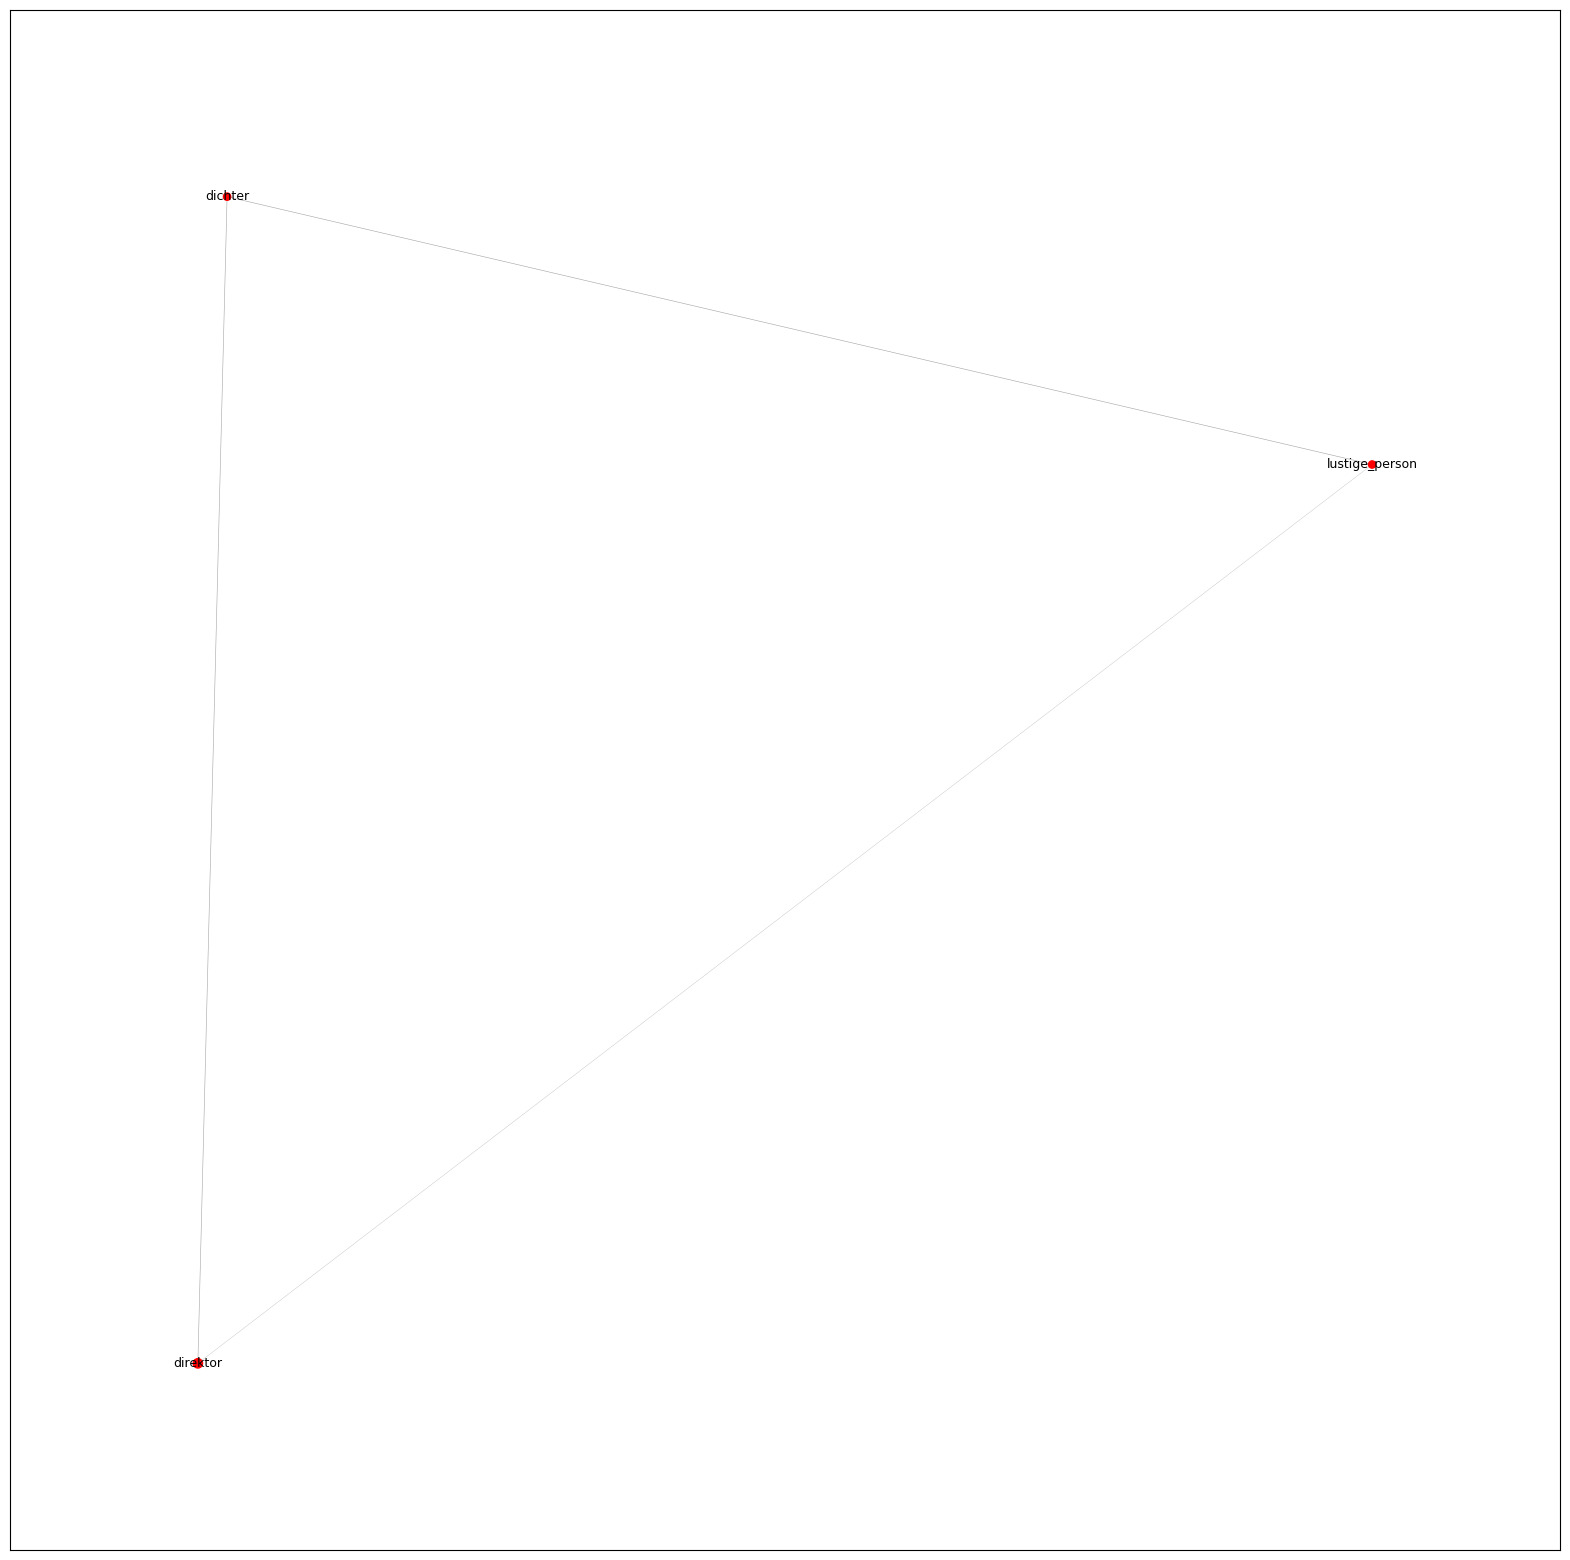

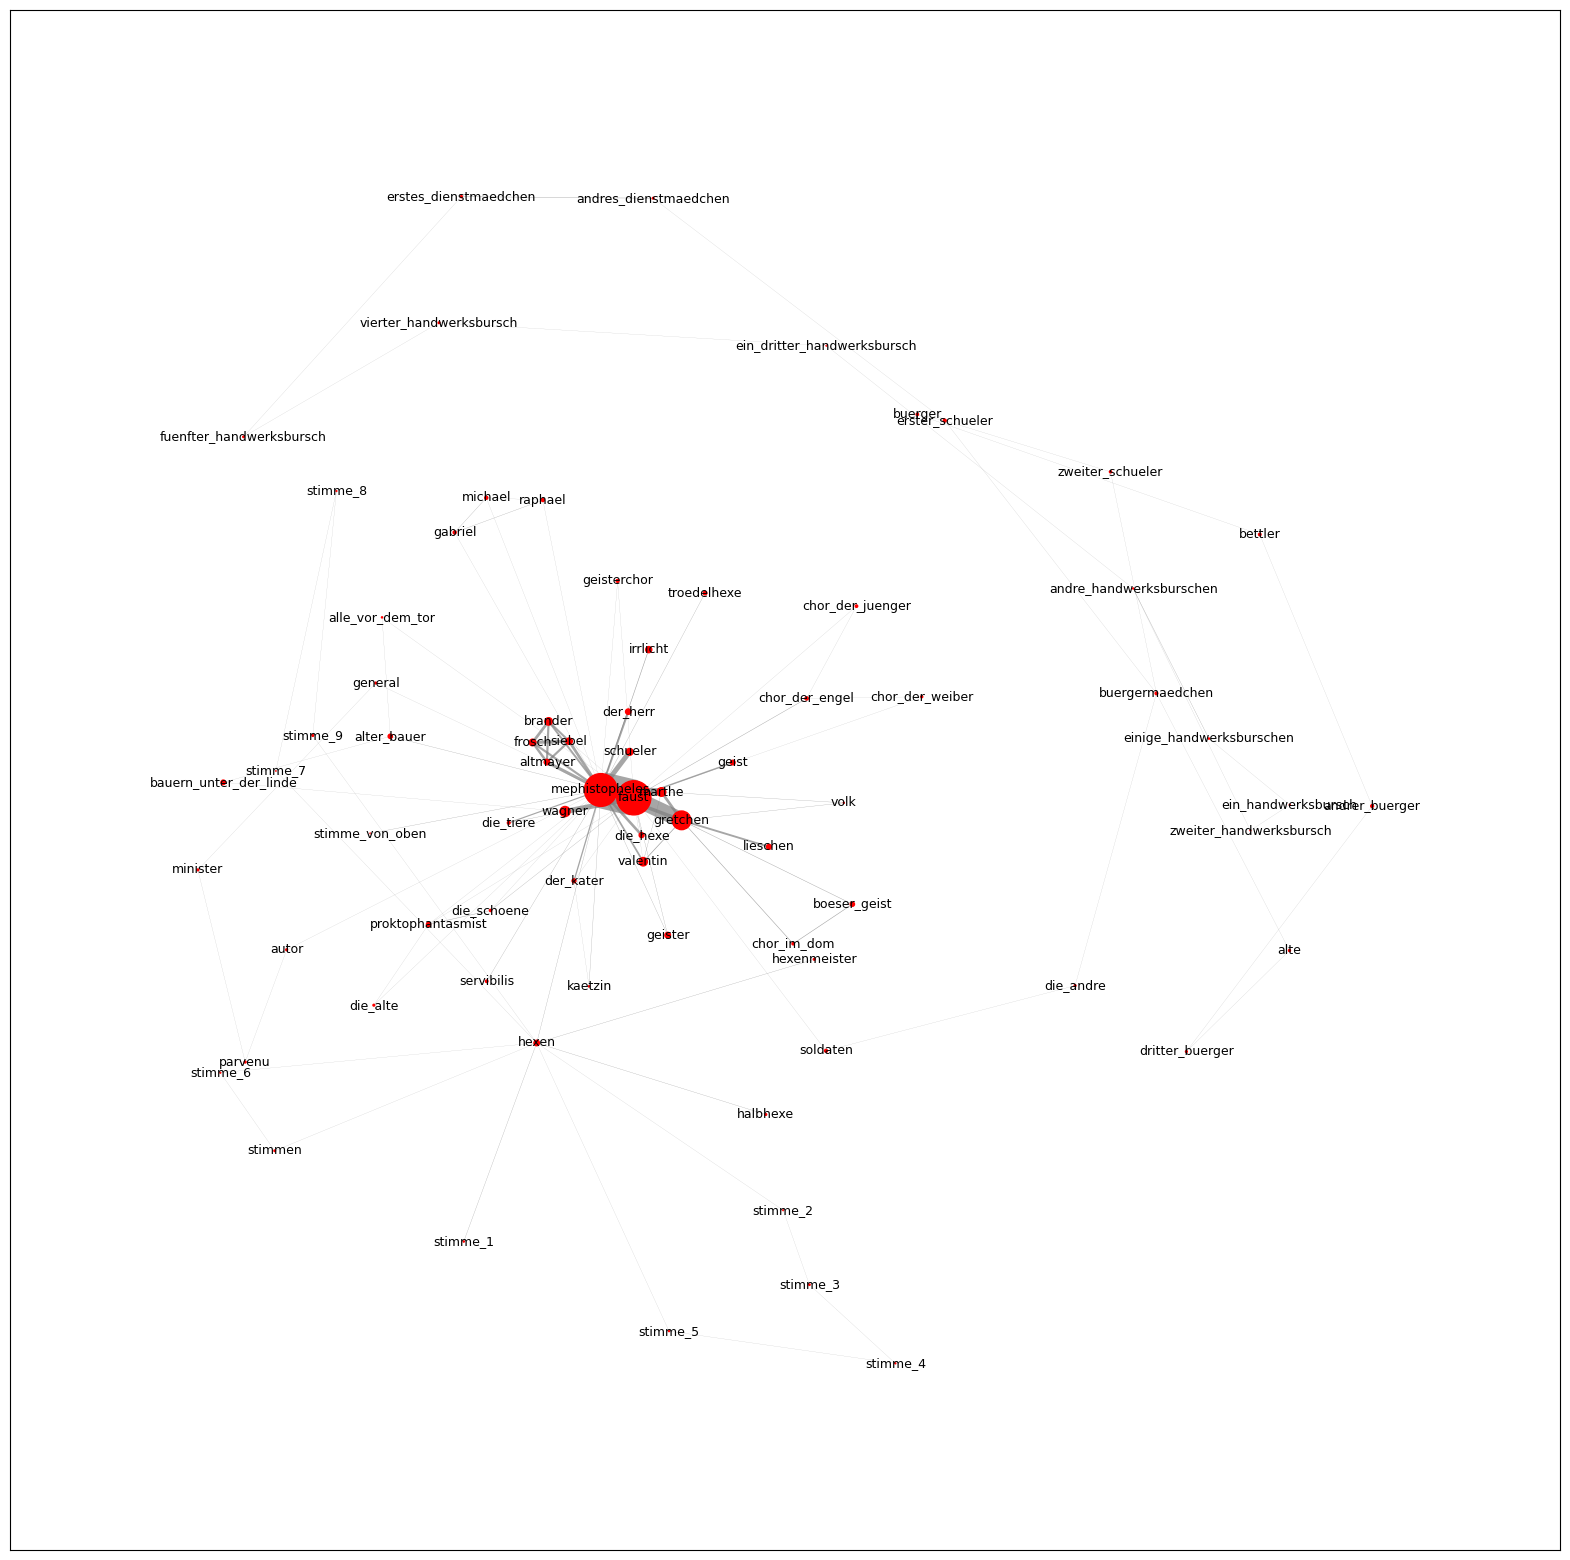

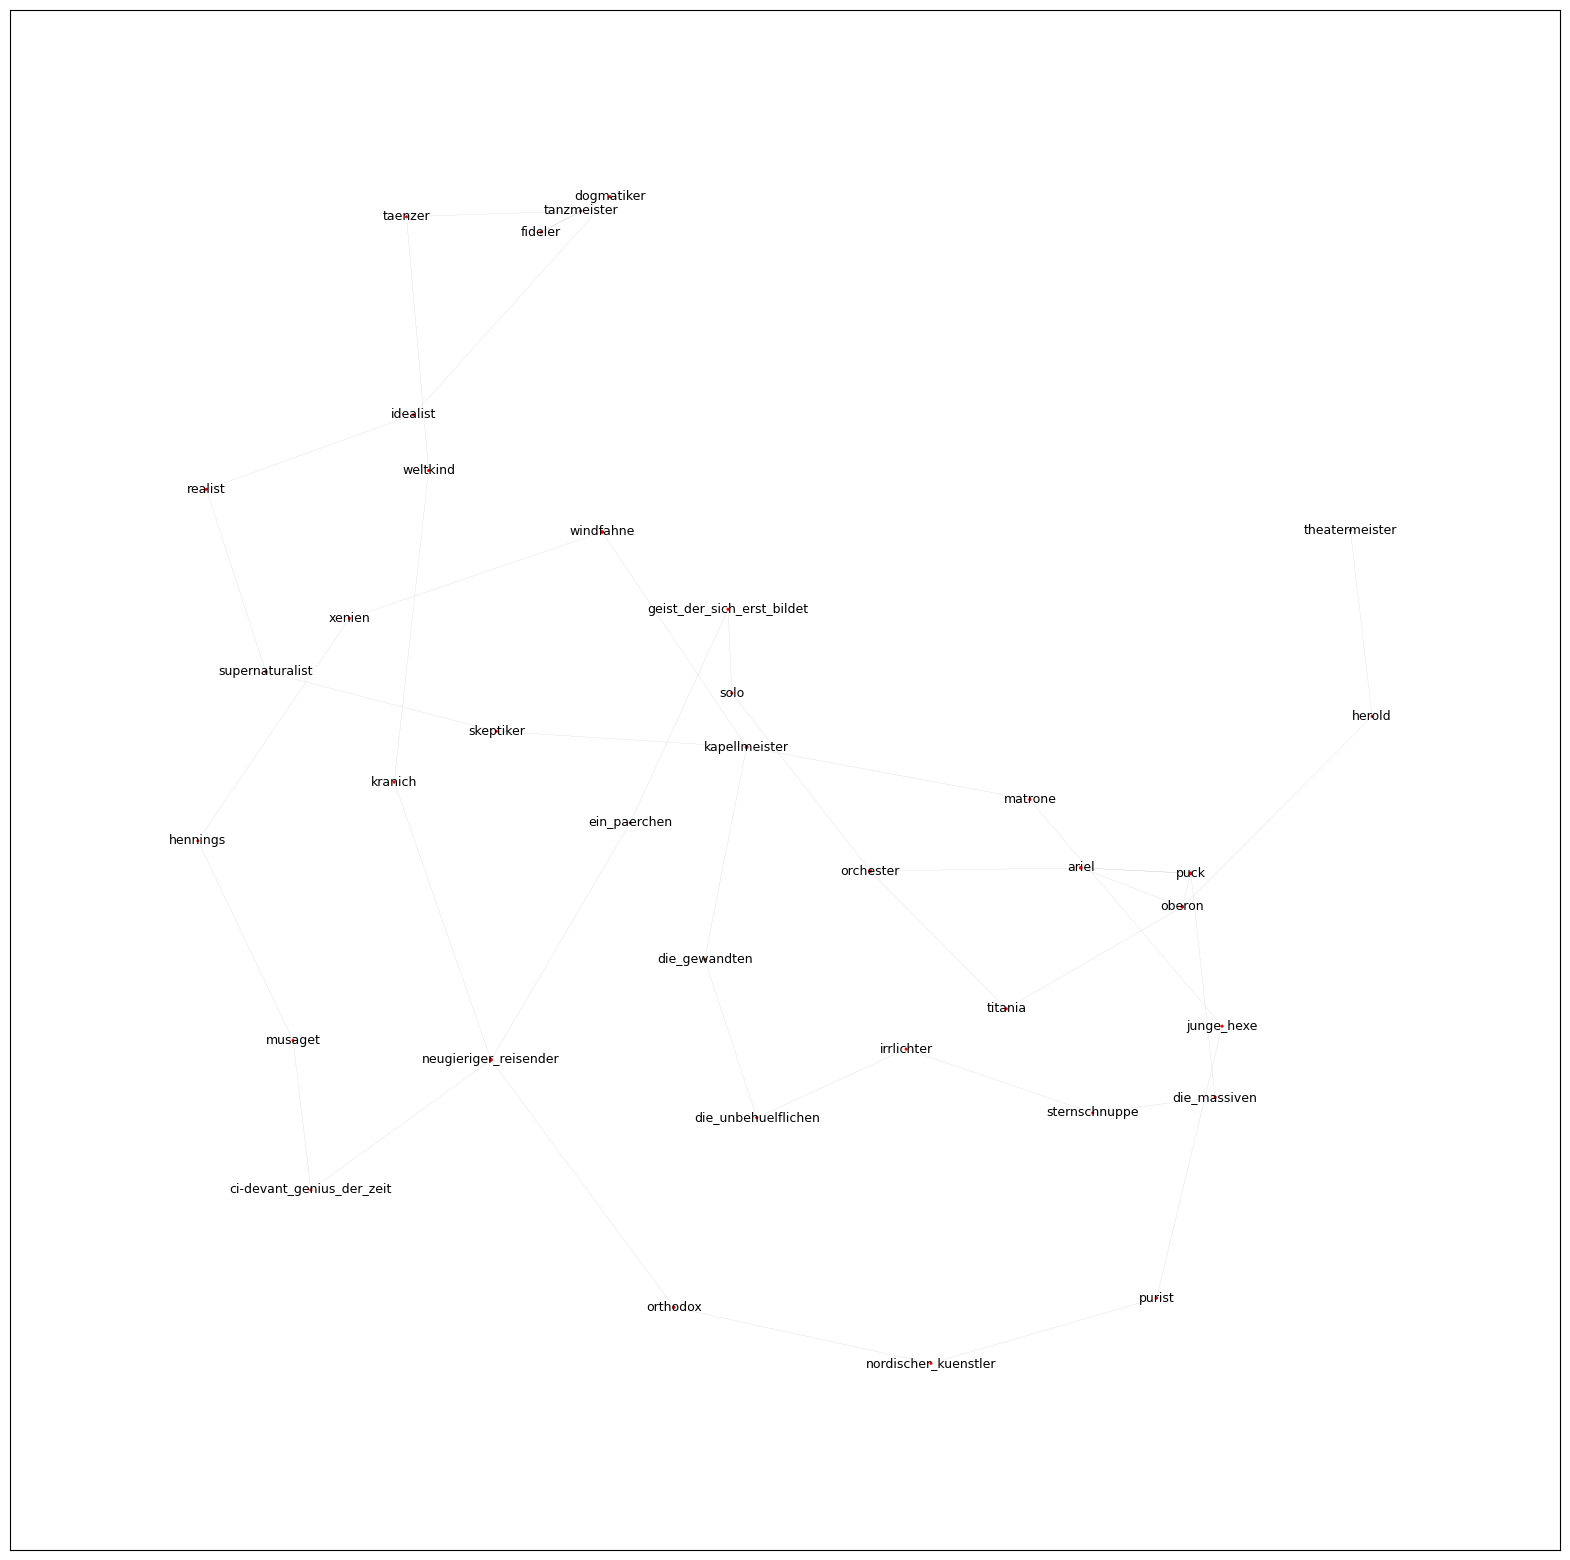

In [19]:
if not nx.is_connected(E):
    components = nx.connected_components(E)
    for nodeset in components:
        G = E.subgraph(nodeset)
        
        plt.rcParams["figure.figsize"]=20,20
        
        pos = nx.spring_layout(G, k=.2)
        
        nx.draw_networkx_nodes(G,
                               pos=pos,
                               node_color='red',
                               node_size=list(nx.get_node_attributes(G, 'text_weight').values())
                              )
        nx.draw_networkx_labels(G,
                                pos=pos,
                                font_size=9,
                                font_color="black"
                               )
        nx.draw_networkx_edges(G,
                               pos=pos,
                               width=list(nx.get_edge_attributes(G, 'weight').values()),
                               edge_color="grey",
                               alpha=.7
                              )
        plt.margins(0.1)
        plt.show()

Ein kreisförmiges Layout kann alles etwas übersichtlicher machen. (networkx bietet eine [ganze Reihe von Layout-Optionen](https://networkx.github.io/documentation/stable/reference/drawing.html). Einfach ausprobieren!)

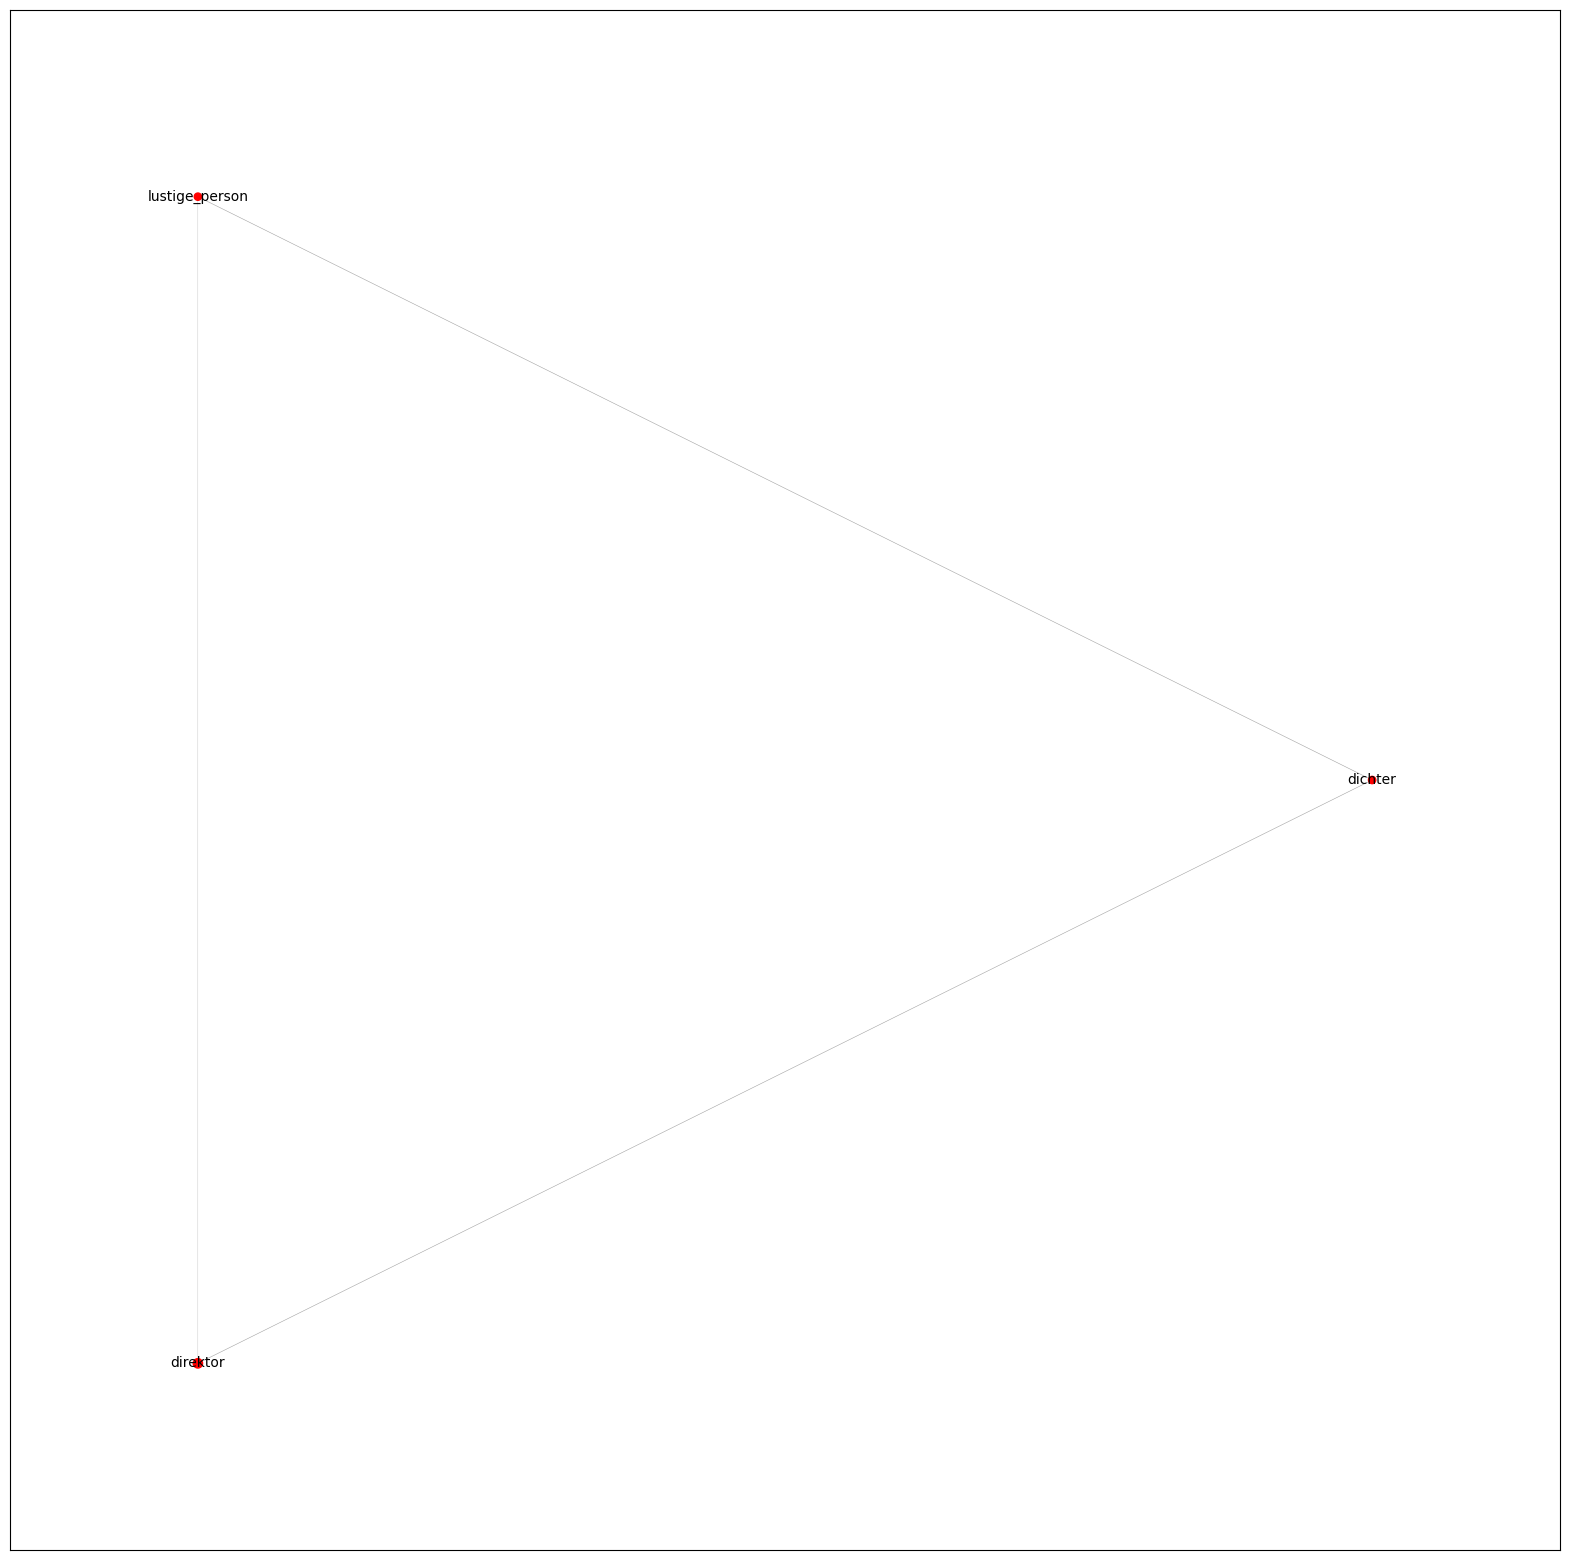

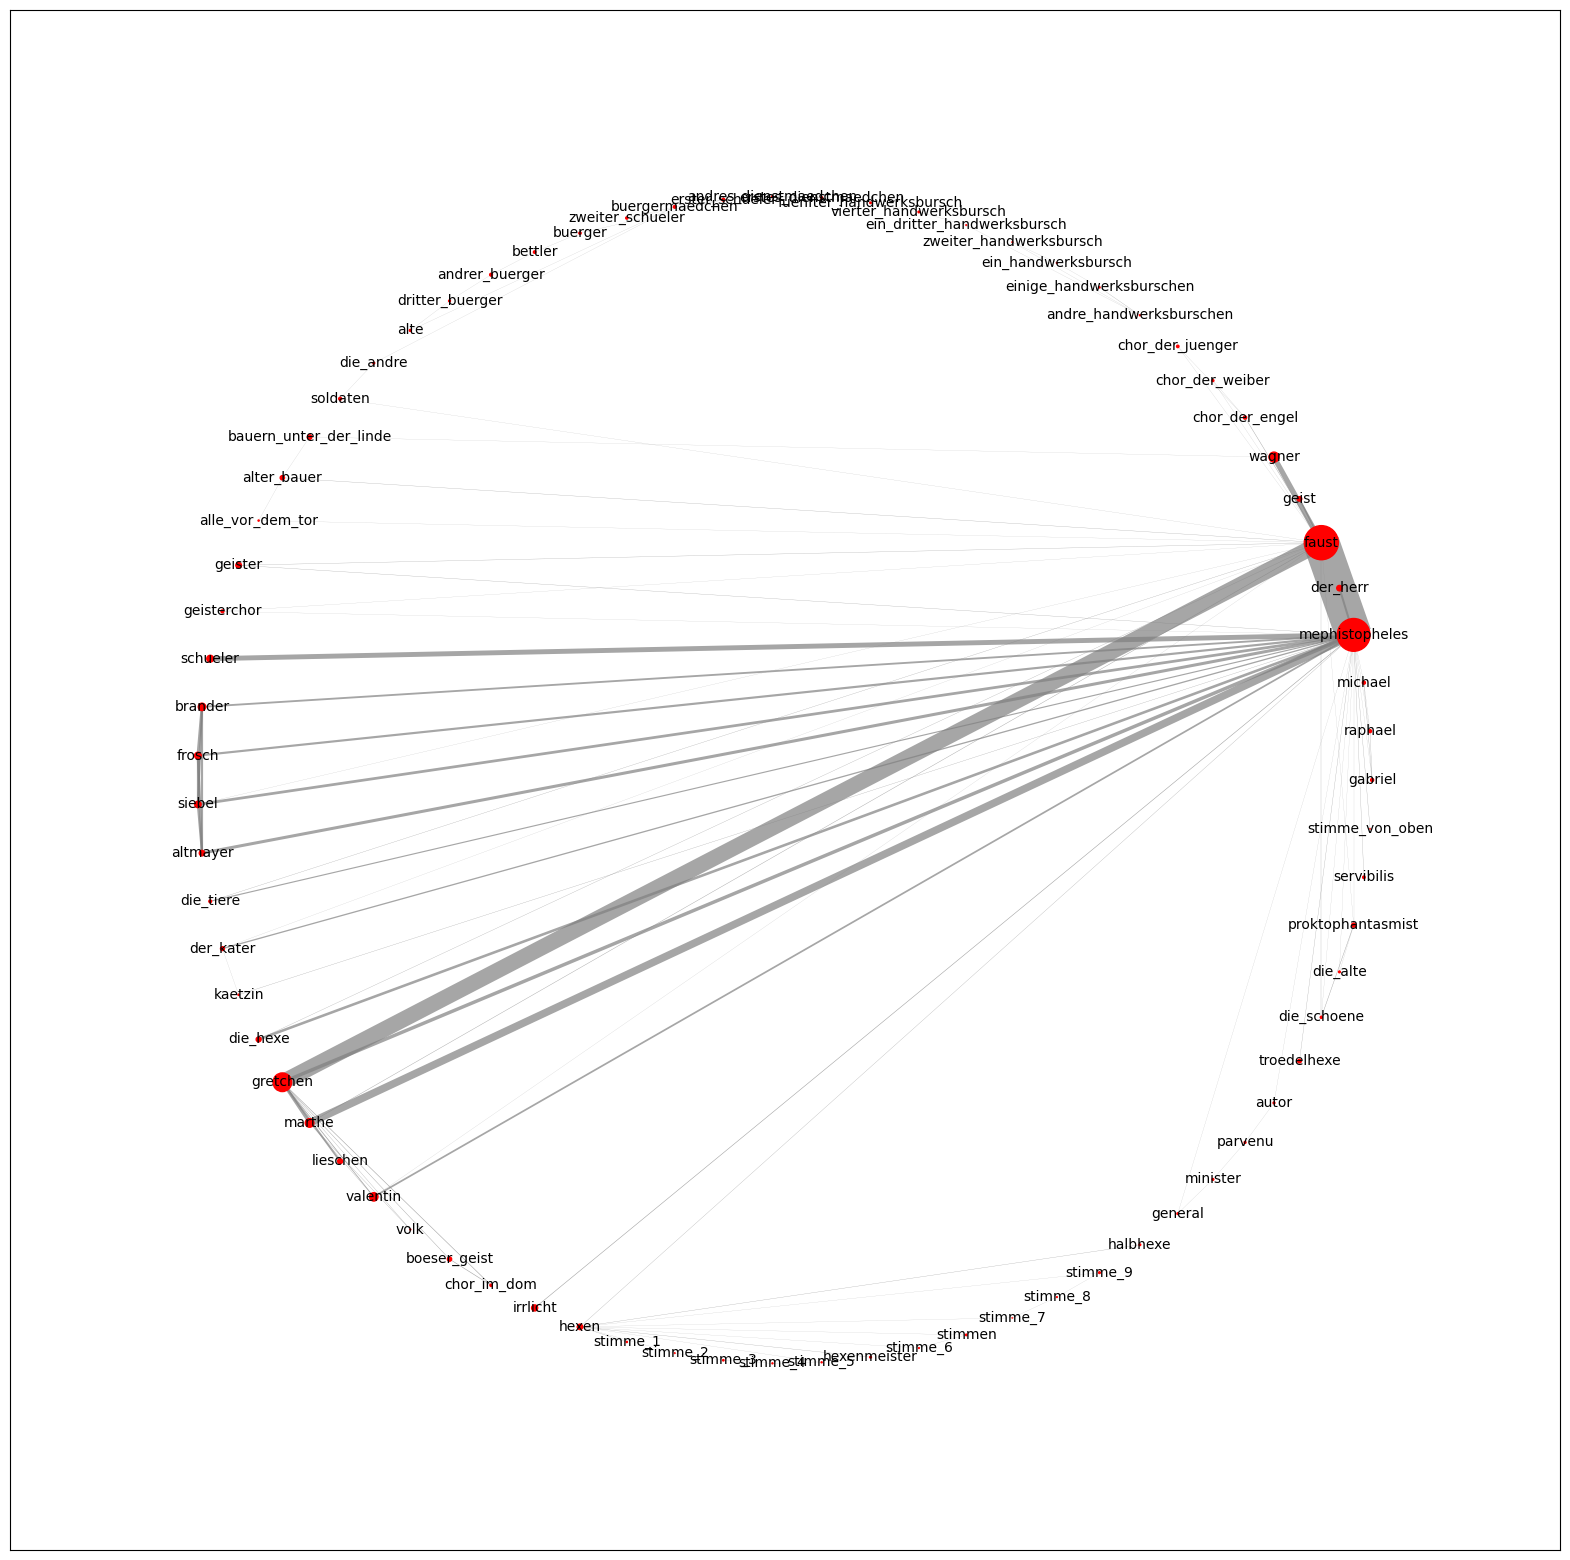

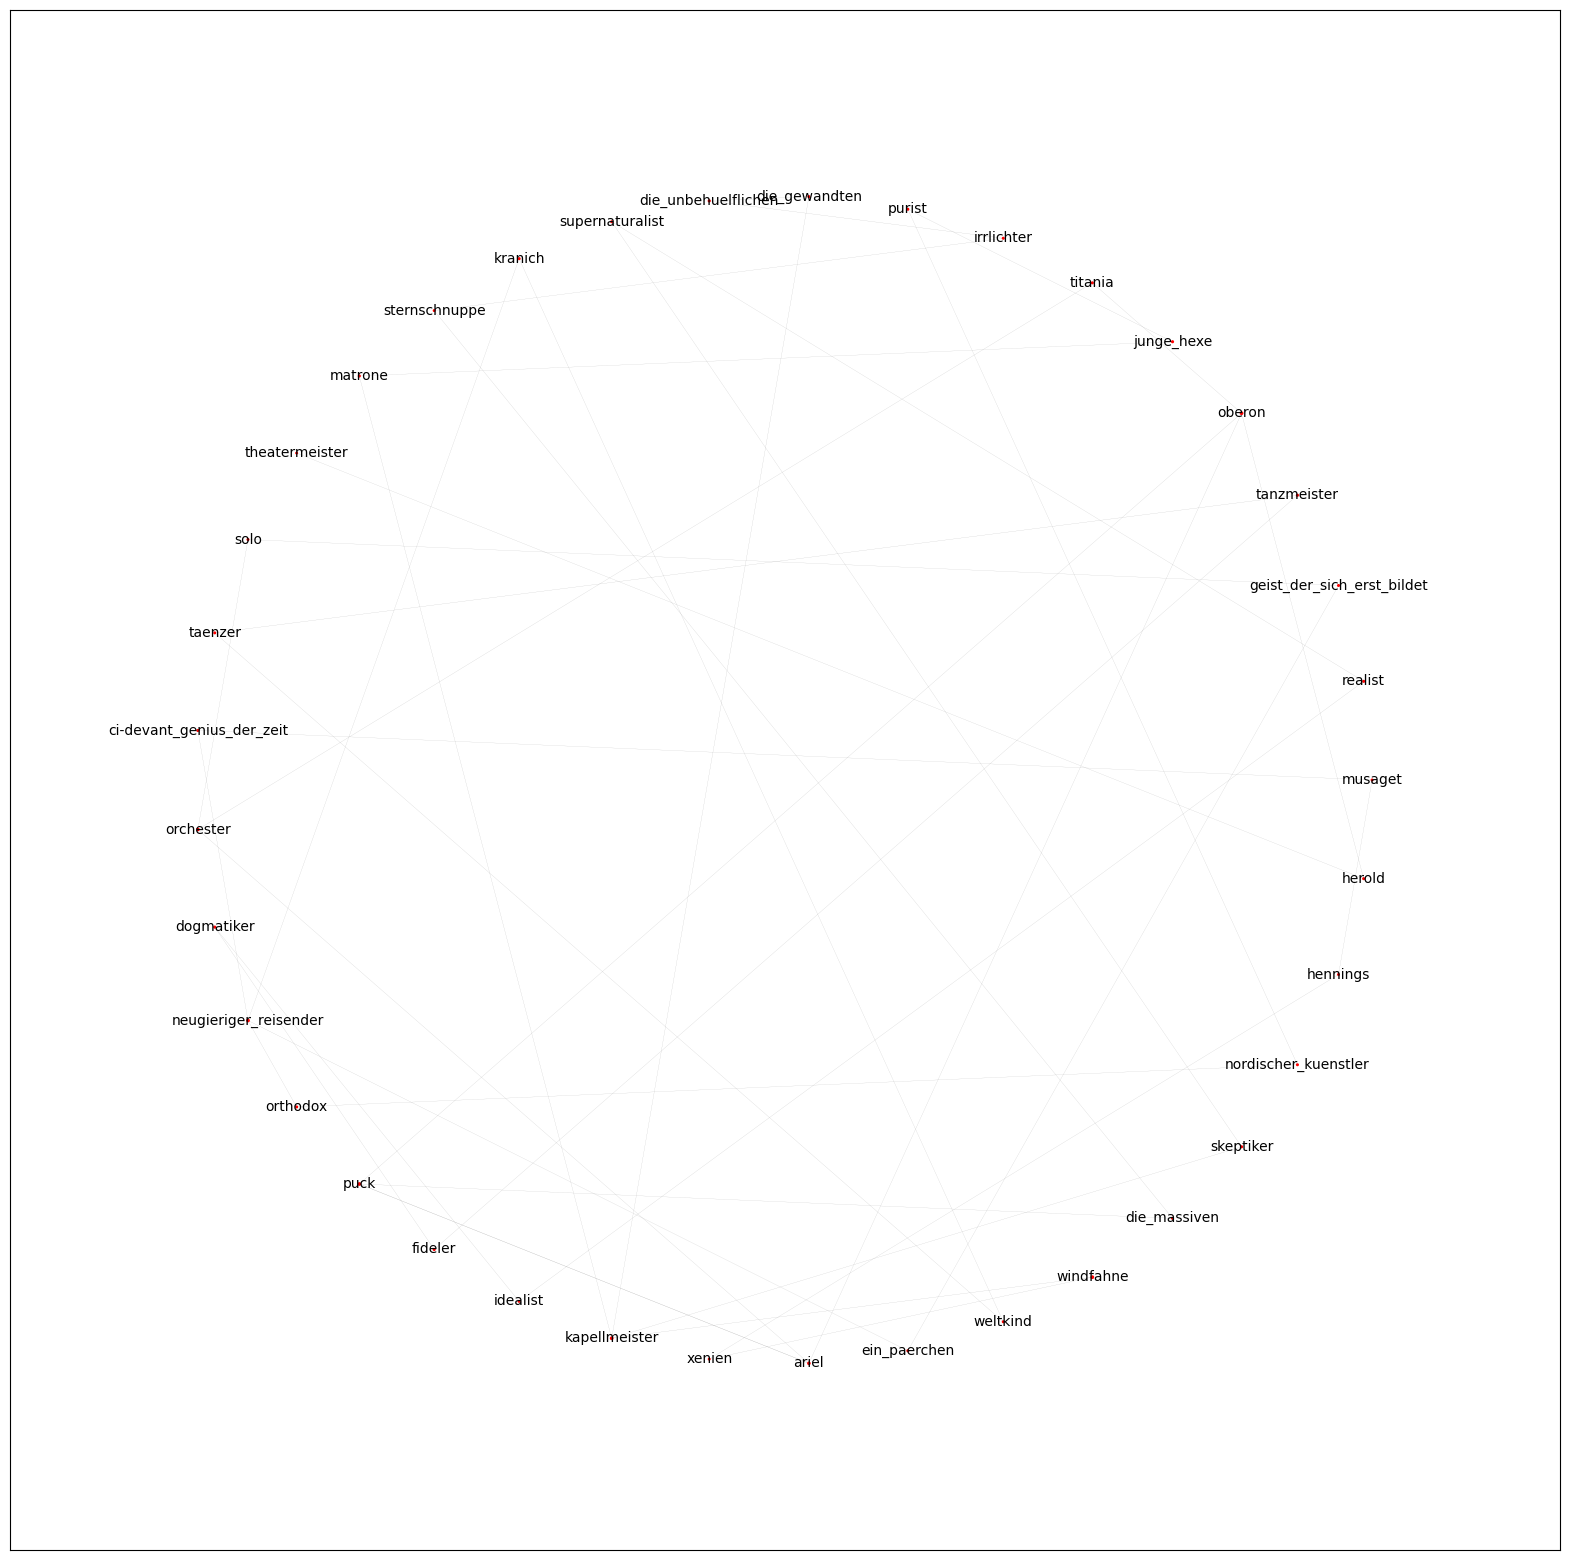

In [20]:
if not nx.is_connected(E):
    components = nx.connected_components(E)
    for nodeset in components:
        G = E.subgraph(nodeset)
        
        plt.rcParams["figure.figsize"]=20,20
        
        pos = nx.circular_layout(G) # hier wird das Layout festgelegt
        nx.draw_networkx_nodes(G,
                               pos=pos,
                               node_color='red',
                               node_size=list(nx.get_node_attributes(G, 'text_weight').values())
                              )
        nx.draw_networkx_labels(G,
                                pos=pos,
                                font_size=10,
                                font_color="black"
                               )
        nx.draw_networkx_edges(G,
                               pos=pos,
                               width=list(nx.get_edge_attributes(G, 'weight').values()),
                               edge_color="grey",
                               alpha=.7
                              )
        plt.margins(0.1)
        plt.show()

## Zentralitätsmaße
Es gibt [eine ganze Reihe von Methoden](https://networkx.github.io/documentation/stable/reference/algorithms/centrality.html), um zentrale Knoten in einem Graphen zu ermitteln. Da diese unterschiedliche Aspekte beleuchten, gibt es hier kein "bestes" Maß. Man sollte stattdessen genauer definieren, was man in einem konkreten Netzwerk als zentral oder wichtig erachtet und anschließend ein Zentralitätsmaß wählen, das diese Intuition am besten widerspiegelt. Sind in einem Figurennetzwerk etwa Figuren wichtig, die besonders viele Verbindungen zu anderen aufweisen? Oder diejenigen, die mit vielen anderen wichtigen Figuren verbunden sind? Oder diejenigen, die Teilnetzwerke überhaupt miteinander verbinden, also eine besondere Position im Netzwerk haben?

Die Graphik von [Wikipedia/Nutzer Tapiocozzo](https://de.wikipedia.org/wiki/Soziale_Netzwerkanalyse#/media/Datei:6_centrality_measures.png) zeigt anschaulich, wie verschiedene Zentralitätsmaße unterschiedliche Bereiche desselben Netzwerks hervorheben.

### Gradzentralität
Den Grad (*degree*) jedes Knotens, also die Anzahl der Verbindungen, die der Knoten mit anderen Knoten hat, haben wir eben bereits festgehalten.  (Bei gerichteten Graphen unterscheidet man noch zwischen eingehenden und ausgehenden Verbindungen: *in-degree* und *out-degree*.) Je höher der Grad eines Knotens, als desto zentraler kann er gelten – man spricht deshalb auch von Gradzentralität (*degree centrality*).

Teilt man den Grad durch die Anzahl potentieller Verbindungen (oder Nachbarn), normalisiert man die Gradzentralität, macht sie also für verschieden große Graphen vergleichbar. Das ist auch das, was `degree_centrality()` tut: 

In [21]:
dc = nx.degree_centrality(E) # die Werte können wir für unseren Graphen auch so erhalten: [len(list(E.neighbors(n))) / (len(E) - 1) for n in E.nodes()]
nx.set_node_attributes(E, dc, 'degree_centrality') # für später gleich als Knotenattribut setzen
pd.Series(dc).sort_values(ascending=False) # Umwandlung in Series-Objekt zur platzsparenden und sortierten Ausgabe (um alle Werte sortiert zu sehen, einfach nochmal dict() außenrum)

mephistopheles     0.254386
faust              0.175439
hexen              0.087719
gretchen           0.070175
marthe             0.043860
                     ...   
theatermeister     0.008772
irrlicht           0.008772
lieschen           0.008772
schueler           0.008772
stimme_von_oben    0.008772
Length: 115, dtype: float64

Wie sind die Werte verteilt? Sehen wir uns ein Histogramm an:

In [22]:
fig = px.histogram(x=list(dc.values())) # wir wollen hier nur die Dictionary-Werte (und zwar als Liste)
fig.update_layout(
    title="Histogramm: Gradzentralität",
    xaxis_title="Normalisierte Gradzentralität",
    yaxis_title="Absolute Häufigkeit",
    template="ggplot2"
)
fig.show()

Wenig überraschend sind die beiden Figuren mit der höchsten Gradzentralität Mephistopheles und Faust, gefolgt von den Hexen (huch!) und Gretchen.

Wichtig zu wissen: Die Gewichte der Kanten (in unserem Fall also die Interaktionszahlen oder relativen Häufigkeiten) gingen hier nicht in die Berechnung ein. Wir könnten als Grad eines Knotens natürlich auch die Summe der Gewichte seiner Verbindungen berechnen – nur die Normalisierung wäre dann schwieriger, denn was wäre der potentielle maximale Grad?

### Zwischenzentralität
Knoten können nicht nur wichtig sein, wenn sie besonders viele Verbindungen zu anderen Knoten haben, sondern auch, wenn sie besonders wichtig sind, um den (indirekten) Kontakt zwischen vielen Knoten herzustellen, also als Mittler.

In folgendem Beispiel hat z.B. der Knoten `E` nur zwei Verbindungen, ist aber zentral, um die stärker vernetzten Teilnetzwerke miteinander zu verbinden:

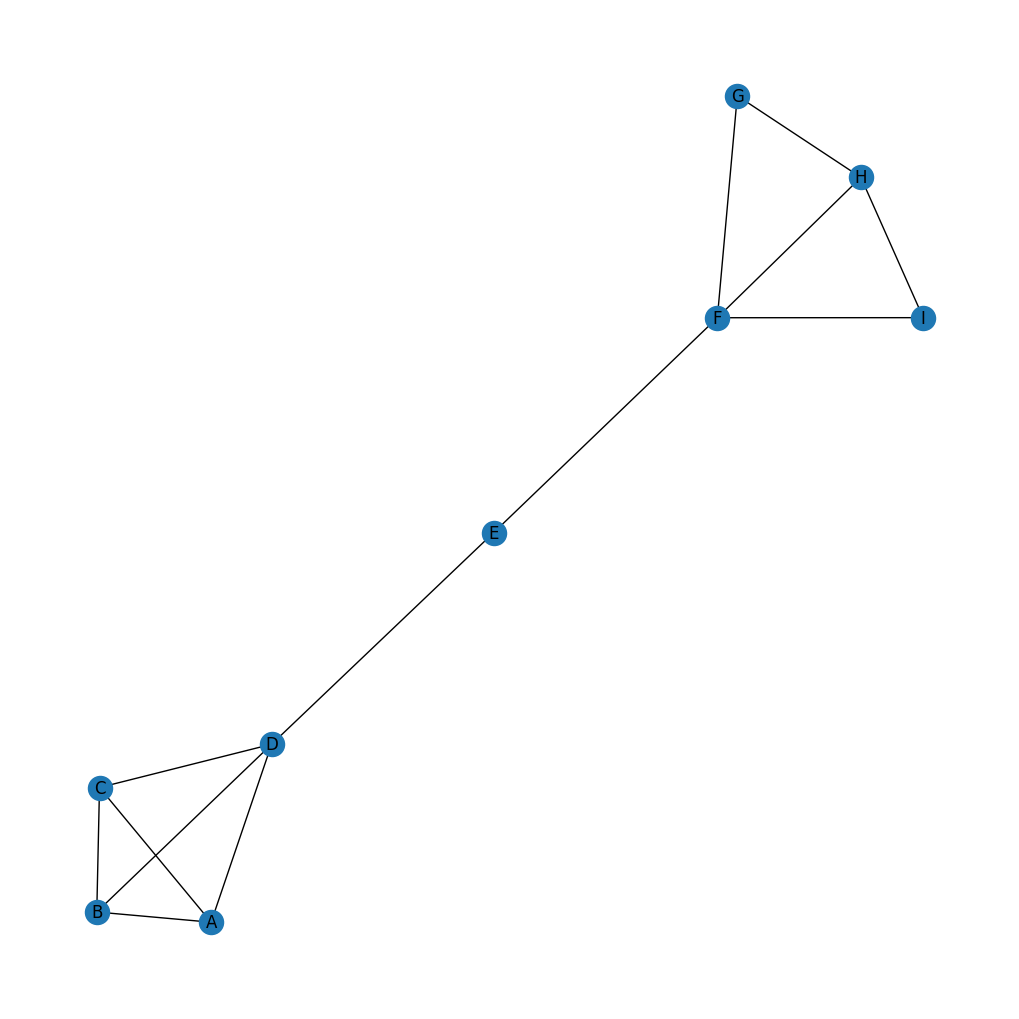

In [23]:
B = nx.Graph()
B.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])
B.add_edges_from([('A', 'B'), ('B', 'C'), ('A', 'C'), ('C', 'D'), ('D', 'A'), ('D', 'B'), ('D', 'E'), ('E', 'F'), ('F', 'G'), ('G', 'H'), ('H', 'I'), ('H', 'F'), ('I', 'F')])

plt.rcParams["figure.figsize"]=10,10
nx.draw(B, with_labels=True)
plt.show()

Die Zwischenzentralität (*betweenness centrality*) eines Knotens gibt an, auf wie vielen [kürzesten Pfaden](https://networkx.github.io/documentation/stable/reference/algorithms/shortest_paths.html) zwischen anderen Knoten er liegt:

In [24]:
nx.betweenness_centrality(B, normalized=False)

{'A': 0.0,
 'B': 0.0,
 'C': 0.0,
 'D': 15.0,
 'E': 16.0,
 'F': 15.5,
 'G': 0.0,
 'H': 0.5,
 'I': 0.0}

Ein Wert wie 0,5 für `H` ergibt sich, wenn ein Pfad, auf dem der Knoten liegt, nur einer von mehreren möglichen kürzesten Pfaden ist (in diesem Fall kann man von `I` zu `G` auf kürzestem Wege entweder über `H` oder über `F` gehen).

Um die Werte der Zwischenzentralität unabhängig von der Größe des Netzwerks zu machen, bietet es sich an, sie zu normalisieren, indem man sie durch die maximale Zwischenzentralität teilt, die für ein Netzwerk mit einer entsprechenden Knotenzahl möglich wäre (`0.5 * (Knotenzahl - 1) * (Knotenzahl - 2)`). Der Graph `B` hat 9 Knoten, der Wert für den Knoten `E` wäre demnach:

In [25]:
15 / (0.5 * (9 - 1) * (9 - 2))

0.5357142857142857

Ohne `normalized=False` macht `betweenness_centrality()` das gleich automatisch:

In [26]:
nx.betweenness_centrality(B)

{'A': 0.0,
 'B': 0.0,
 'C': 0.0,
 'D': 0.5357142857142857,
 'E': 0.5714285714285714,
 'F': 0.5535714285714285,
 'G': 0.0,
 'H': 0.017857142857142856,
 'I': 0.0}

Für *Faust* fällt auf, dass Mephistopheles und Faust auch hierbei die höchsten Werte erreichen, Gretchen aber einen ziemlich niedrigen Wert hat (~0,04):

In [27]:
bc = nx.betweenness_centrality(E)
nx.set_node_attributes(E, bc, 'betweenness_centrality')
pd.Series(bc).sort_values(ascending=False)

mephistopheles     0.260053
faust              0.230321
soldaten           0.156497
die_andre          0.150442
buergermaedchen    0.147726
                     ...   
boeser_geist       0.000000
volk               0.000000
valentin           0.000000
lieschen           0.000000
stimme_von_oben    0.000000
Length: 115, dtype: float64

Anders als bei der Gradzentralität ist es bei der Zwischenzentralität auch möglich, Kantengewichte zu berücksichtigen. Als kürzester Pfad zwischen zwei Knoten wird dann derjenige gewertet, der die Summe der Kantengewichte auf dem Pfad minimiert.

In unserem Fall ergibt das allerdings wenig Sinn: Unsere Gewichte geben ja keine Entfernungen zwischen Charakteren an (wobei eine kürzere Entfernung wahrscheinlich eine stärkere Verbindung implizieren würde), sondern Interaktionshäufigkeiten. Damit wir die Gewichte sinnvoll berücksichtigen können, müssten sie also bei hoher Interaktionshäufigkeit kleiner sein als bei niedriger.

Eine sehr einfache Methode dafür wäre z.B., für jede Kante den Kehrwert der Interaktionshäufigkeit zu nehmen:

In [28]:
kehrwerte = {key:1/value for key, value in nx.get_edge_attributes(E, 'frequency').items()} # wieder ein Dictionary mit je zwei Knoten und dem berechneten Kehrwert
nx.set_edge_attributes(E, kehrwerte, 'inverse_frequency')

Damit lassen sich nun die Zwischenzentralitätswerte auch mit Berücksichtigung der Kantengewichte einigermaßen sinnvoll berechnen:

In [29]:
bcw = nx.betweenness_centrality(E, weight='inverse_frequency')
nx.set_node_attributes(E, bcw, 'betweenness_centrality_weighted')
pd.Series(bcw).sort_values(ascending=False)

mephistopheles     0.301273
faust              0.268592
soldaten           0.156497
die_andre          0.150442
buergermaedchen    0.147726
                     ...   
marthe             0.000000
die_hexe           0.000000
kaetzin            0.000000
der_kater          0.000000
stimme_von_oben    0.000000
Length: 115, dtype: float64

Ein Beispiel dafür, dass das tatsächlich einen Mehrwert haben kann:

Wenn uns der kürzeste Pfad zwischen Wagner und Siebel interessiert, ist das ohne Berücksichtigung der Interaktionshäufigkeiten dieser:

In [30]:
nx.shortest_path(E, 'wagner', 'siebel')

['wagner', 'faust', 'siebel']

Der kürzeste Pfad führt also direkt über Faust. Aber sehen wir uns mal die Interaktionshäufigkeiten an (Wagner – Faust, Faust – Siebel):

In [31]:
E.edges['wagner', 'faust']

{'frequency': 36,
 'weight': 3.7383177570093453,
 'inverse_frequency': 0.027777777777777776}

In [32]:
E.edges['faust', 'siebel']

{'frequency': 1, 'weight': 0.10384215991692627, 'inverse_frequency': 1.0}

Faust und Siebel haben also nur einmal interagiert – keine besonders starke Verbindung!

Was kommt denn heraus, wenn wir den kürzesten Pfad anhand der (Kehrwerte der) Interaktionshäufigkeiten berechnen?

In [33]:
nx.shortest_path(E, 'wagner', 'siebel', weight='inverse_frequency') # hier wird standardmäßig der Dijkstra-Algorithmus verwendet

['wagner', 'faust', 'mephistopheles', 'siebel']

In [34]:
E.edges['faust', 'mephistopheles']

{'frequency': 251,
 'weight': 26.064382139148496,
 'inverse_frequency': 0.00398406374501992}

In [35]:
E.edges['mephistopheles', 'siebel']

{'frequency': 19,
 'weight': 1.9730010384215992,
 'inverse_frequency': 0.05263157894736842}

Hier geht der Pfad nun also über Mephistopheles, der (natürlich) extrem stark mit Faust verbunden ist, aber selbst deutlich stärker mit Siebel als Faust selbst. Das ist nun zwar eine Person mehr, dafür geht der Pfad aber über stärkere Verbindungen.

### Nähe
Nähe (*closeness centrality*) ist ein weiteres Zentralitätsmaß, das (Überraschung!) für einen Knoten angibt, wie nah er an allen anderen Knoten im Graphen ist. Um die Nähe für einen Knoten zu berechnen, berechnet man zunächst die kürzesten Pfade zu allen anderen Knoten im Graphen, summiert deren Längen und bildet schließlich den Kehrwert der Summe.

Nehmen wir als einfaches Beispiel zuerst wieder unseren Graphen `B` von oben:

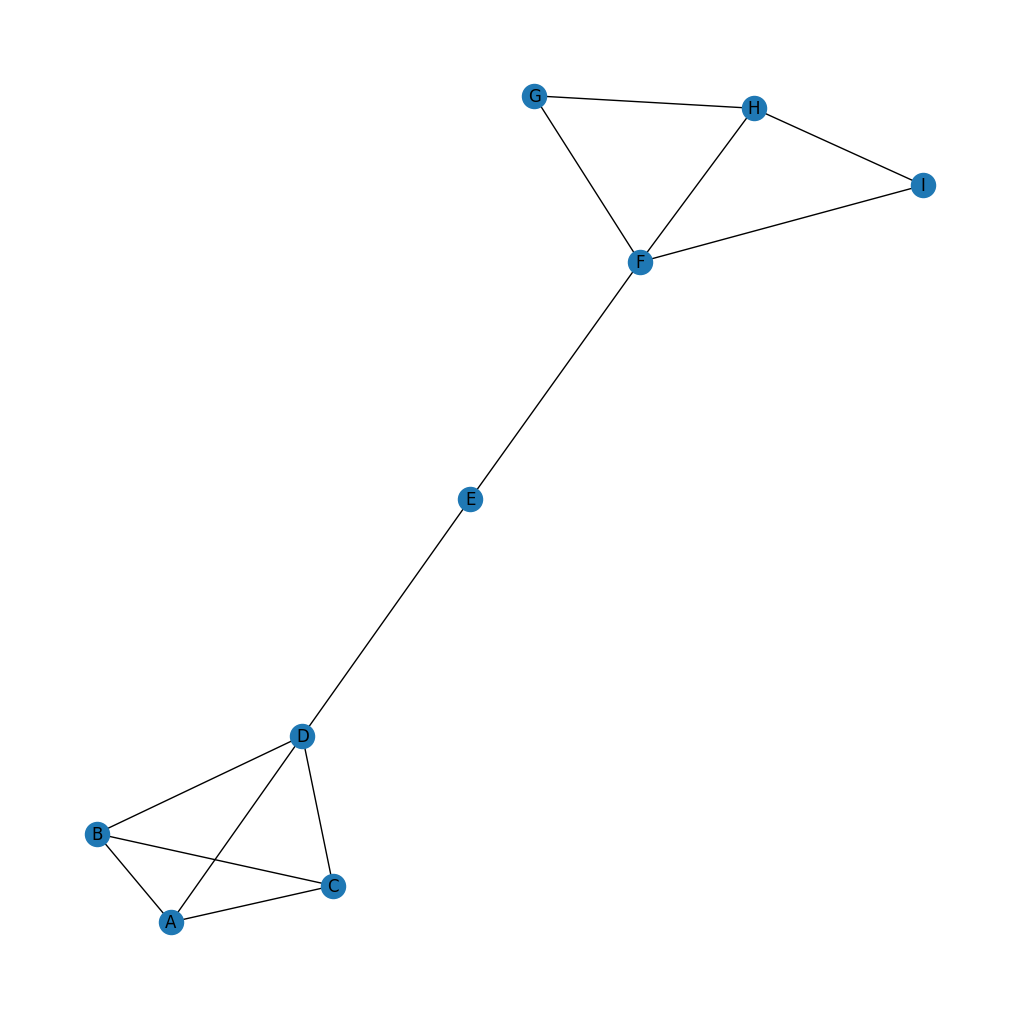

In [36]:
plt.rcParams["figure.figsize"]=10,10
nx.draw(B, with_labels=True)
plt.show()

Um manuell die Nähe für den Knoten `E` zu berechnen, brauchen wir zuerst die Längen aller kürzesten Pfade von `E` zu den anderen Knoten:

In [37]:
distances = []
for node in B.nodes():
    if node != 'E':
        dist = len(nx.shortest_path(B, 'E', node)) - 1 # -1, weil E selbst natürlich nicht mitgezählt werden sollte
        distances.append(dist)
distances

[2, 2, 2, 1, 1, 2, 2, 2]

In [38]:
1/sum(distances)

0.07142857142857142

Üblich ist es, diesen Wert wieder zu normalisieren, um Werte von Graphen unterschiedlicher Größe vergleichen zu können. Dazu nimmt man statt der Summe das arithmetische Mittel der Pfadlängen:

In [39]:
1/np.mean(distances) # = len(distances)/sum(distances)

0.5714285714285714

Das entspricht nun dem, was `closeness_centrality()` für alle Knoten ausgibt:

In [40]:
nx.closeness_centrality(B)

{'A': 0.4,
 'B': 0.4,
 'C': 0.4,
 'D': 0.5333333333333333,
 'E': 0.5714285714285714,
 'F': 0.5333333333333333,
 'G': 0.38095238095238093,
 'H': 0.4,
 'I': 0.38095238095238093}

Wichtig zu wissen ist noch, dass nur Pfade zu erreichbaren Knoten berücksichtigt werden. Wenn ein Graph also aus unverbundenen Teilnetzwerken besteht, werden die Werte nur anhand der Pfade innerhalb dieser Teilnetzwerke berechnet. Das kann dazu führen, dass Knoten aus sehr kleinen separaten Teilnetzwerken wesentlich höhere Nähewerte erhalten als sehr zentrale Knoten aus einem deutlich größeren Teilnetzwerk. In *Faust* hätten beispielsweise `lustige_person`, `dichter` und `direktor` die höchsten Nähewerte, weil diese drei Figuren ein solches separates Teilnetzwerk bilden.

Um dieses Problem zu umgehen, haben Wasserman und Faust (ein anderer ;)) vorgeschlagen, die Werte hiermit zu multiplizieren: Anzahl erreichbarer Knoten / (Anzahl aller Knoten im Graphen - 1). Wenn der ganze Graph zusammenhängend ist, ergibt sich dadurch keine Änderung der Werte (weil dann Zähler und Nenner gleich sind). Sofern man bei `closeness_centrality()` das Argument `wf_improved` nicht auf `False` setzt, wird automatisch die Anpassung von Wasserman und Faust verwendet.

So erreichen in *Faust* die eben erwähnten Figuren denn auch die niedrigsten Nähewerte:

In [41]:
cc = nx.closeness_centrality(E)
nx.set_node_attributes(E, cc, 'closeness_centrality')
pd.Series(cc).sort_values(ascending=False)

mephistopheles    0.215404
faust             0.211608
gretchen          0.186183
marthe            0.184042
valentin          0.183340
                    ...   
herold            0.043226
theatermeister    0.038149
lustige_person    0.017544
direktor          0.017544
dichter           0.017544
Length: 115, dtype: float64

Wie bei der Zwischenzentralität lassen sich auch bei der Berechnung der Nähe die kürzesten Pfade über Kantengewichte ermitteln:

In [42]:
ccw = nx.closeness_centrality(E, distance='inverse_frequency')
nx.set_node_attributes(E, ccw, 'closeness_centrality_weighted')
pd.Series(ccw).sort_values(ascending=False)

mephistopheles    0.310257
faust             0.310233
gretchen          0.309043
marthe            0.307533
wagner            0.306331
                    ...   
idealist          0.045933
fideler           0.045565
dogmatiker        0.044758
herold            0.043226
theatermeister    0.038149
Length: 115, dtype: float64

### Eigenvektorzentralität
Die Idee hinter der Eigenvektorzentralität ist, dass ein Knoten wichtig ist, wenn er mit anderen wichtigen Knoten verbunden ist. Das klingt etwas zirkulär, lässt sich aber lösen – auch wenn das etwas komplizierter wird ...

Eine sehr anschauliche Erläuterung gibt es hier: http://djjr-courses.wikidot.com/soc180:eigenvector-centrality

Die Nachbarschaftsmatrix (oder [Adjazenzmatrix](https://de.wikipedia.org/wiki/Adjazenzmatrix), engl. *adjacency matrix*) ist, wie schon eingangs erwähnt, ein anderes Repräsentationsformat für einen Graphen. Hier gibt es für jeden Knoten des Graphen sowohl eine Reihe als auch eine Spalte in der Matrix. Gibt es eine Kante (also eine Verbindung) zwischen zwei unterschiedlichen Knoten, steht an den beiden entsprechenden Stellen eine 1, sonst eine 0 (dass es zwei Stellen sind, liegt daran, dass jeder Knoten sowohl als Zeile als auch als Spalte vorkommt). Alternativ kann man statt einer 1 auch das jeweilige Kantengewicht in der Matrix verwenden. Wenn man die Kantengewichte als Kosten/Weglängen betrachtet, kann man bei einer fehlenden Verbindung anstelle einer 0 auch ∞ (unendlich) eintragen.

In [43]:
nx.to_pandas_adjacency(B, weight=None, dtype=int)
# nx.to_pandas_adjacency(E, weight='frequency') # mit Gewichten

A  B  C  D  E  F  G  H  I
A  0  1  1  1  0  0  0  0  0
B  1  0  1  1  0  0  0  0  0
C  1  1  0  1  0  0  0  0  0
D  1  1  1  0  1  0  0  0  0
E  0  0  0  1  0  1  0  0  0
F  0  0  0  0  1  0  1  1  1
G  0  0  0  0  0  1  0  1  0
H  0  0  0  0  0  1  1  0  1
I  0  0  0  0  0  1  0  1  0

Die Nachbarschaftsmatrix eines ungerichteten Graphen ist symmetrisch und damit identisch zur transponierten Matrix (das ist die Matrix, die man erhält, wenn man Zeilen und Spalten vertauscht). Wenn alle Elemente der Hauptdiagonalen (Linie von links oben nach rechts unten) 0 sind, ist der Graph außerdem schleifenfrei (es gibt also keine Verbindungen von Knoten mit sich selbst).

Wenn $A = (a_{v,w})$ die Nachbarschaftsmatrix eines Graphen $G$ ist (sodass $a_{v,w} = 1$, falls die Knoten $v$ und $w$ verbunden sind, und andernfalls $a_{v,w} = 0$), dann ist die Eigenvektorzentralität $x_{v}$ eines Knotens $v$: $$x_v = \frac{1}{\lambda} \sum_{w \in N(v)} x_w = \frac{1}{\lambda} \sum_{w \in G} a_{v,w} \, x_w$$ Dabei ist $N(v)$ die Menge der Nachbarknoten von $v$ und $\lambda \neq 0$ eine Konstante. Die Eigenvektorzentralität eines Knotens ist also die Summe der Eigenvektorzentralitäten seiner Nachbarknoten geteilt durch $\lambda$.

In Matrixform lässt sich dies folgendermaßen ausdrücken: $$\lambda x = A x$$

$x$ ist ein Vektor, dessen Elemente die Eigenvektorzentralitätswerte der einzelnen Knoten sind.

Diese Gleichung entspricht der [Eigenvektorgleichung](https://de.wikipedia.org/wiki/Eigenwertproblem). Was aber ist überhaupt ein Eigenvektor? Wenn man eine Matrix $A$ mit einem Vektor $x$ multipliziert, erhält man wiederum einen Vektor $y$: $$A x = y$$
Wenn $y$ lediglich ein skalares Vielfaches von $x$ ist (und damit die Richtung nicht ändert), also das Produkt aus $x$ und einem [Skalar](https://de.wikipedia.org/wiki/Skalar_(Mathematik) (einer einfachen Zahl) $\lambda$, dann ist $x$ ein Eigenvektor von $A$ und $\lambda$ ein Eigenwert: $$A x = \lambda x$$

Die Suche nach Zahlen $\lambda_1,\lambda_2,\dots$ und zugehörigen (vom Nullvektor verschiedenen) Vektoren $x_1,x_2,\dots$, die der obigen Eigenvektorgleichung genügen, nennt man *Eigenwertproblem*.

In unserem Fall sind wir gar nicht an *allen* möglichen Eigenwerten und Eigenvektoren (= vollständiges Eigenwertproblem) interessiert, sondern nur am *betragsgrößten* Eigenwert und dem entsprechenden Eigenvektor. Dieser lässt sich über die [Potenzmethode](https://en.wikipedia.org/wiki/Power_iteration) (*power iteration*) ermitteln. (Wenn der Graph (stark) zusammenhängend ist, ist die Nachbarschaftsmatrix $A$ irreduzibel, was nach dem [Satz von Perron-Frobenius](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem) garantiert, dass es einen Eigenvektor mit strikt positiven Elementen zum größten Eigenwert der Matrix gibt.)

Die Potenzmethode zu erklären, würde hier etwas zu weit führen (aber siehe z.B. [hier](http://users.dimi.uniud.it/~massimo.franceschet/teaching/datascience/network/eigenvector.html)). Mit SciPy lässt sich das Eigenwertproblem folgendermaßen lösen:

In [44]:
import scipy as sp
A = nx.to_scipy_sparse_array(B, weight=None, dtype=float) # wenn es hier einen scipy-Fehler gibt, scipy upgraden (>=1.8) oder networkx downgraden (2.6.3)
eigenvalue, eigenvector = sp.sparse.linalg.eigsh(A, k=1, which='LM') # Ermittlung von größtem Eigenwert und zugehörigem Eigenvektor einer symmetrischen Matrix
eigenvector = eigenvector.flatten().real # zu einem einfachen numpy-Array machen, nur den Realteil nehmen (der imaginäre Teil ist eh 0, das ist hier also nur eine Sache der Darstellung)
norm = np.sign(eigenvector.sum()) * sp.linalg.norm(eigenvector) # Normalisierungsquotient
dict(zip(B, eigenvector / norm)) # Dictionary mit Knoten und zugehörigen normalisierten Werten des Eigenvektors = Eigenvektorzentralitätswerte

{'A': 0.461913389669091,
 'B': 0.461913389669091,
 'C': 0.4619133896690913,
 'D': 0.5142616962813036,
 'E': 0.21532582175016668,
 'F': 0.15611848686092034,
 'G': 0.08347612625814145,
 'H': 0.10377018024870792,
 'I': 0.08347612625814149}

Und das entspricht auch dem, was `eigenvector_centrality()` ausgibt (die Alternativfunktion `eigenvector_centrality_numpy()` arbeitet mit der SciPy-Implementierung):

In [45]:
nx.eigenvector_centrality(B)

{'A': 0.4619097180369925,
 'B': 0.4619097180369925,
 'C': 0.4619097180369925,
 'D': 0.514259257123087,
 'E': 0.2153303379043376,
 'F': 0.15613295840562863,
 'G': 0.08348652694903853,
 'H': 0.10378341931953426,
 'I': 0.08348652694903853}

Für *Faust* erhalten wir also folgende Eigenvektorzentralitätswerte (die wir gleich wieder als Knotenattribute speichern):

In [46]:
ec = nx.eigenvector_centrality(E)
nx.set_node_attributes(E, ec, 'eigenvector_centrality')
pd.Series(ec).sort_values(ascending=False)

mephistopheles    5.501909e-01
faust             4.075980e-01
gretchen          2.122888e-01
marthe            2.000189e-01
siebel            1.966062e-01
                      ...     
fideler           1.260683e-08
dogmatiker        1.256824e-08
direktor          8.633998e-09
lustige_person    8.633998e-09
dichter           8.633998e-09
Length: 115, dtype: float64

Auch zur Berechnung der Eigenvektorzentralität lassen sich Kantengewichte verwenden. Anders als bei den vorigen Maßen scheinen hier aber höhere Gewichte stärkere Verbindungen anzuzeigen – wir verwenden also `frequency` oder `weight` als Gewicht.

In [47]:
ecw = nx.eigenvector_centrality(E, weight='weight') # gleiches Ergebnis für weight='frequency', aber Parameter max_iter muss höheren Wert haben, damit der Algorithmus konvergiert
nx.set_node_attributes(E, ecw, 'eigenvector_centrality_weighted')
pd.Series(ecw).sort_values(ascending=False)

faust             6.691254e-01
mephistopheles    6.415980e-01
gretchen          3.079502e-01
marthe            1.392124e-01
wagner            8.119782e-02
                      ...     
realist           8.660564e-89
tanzmeister       6.350651e-89
idealist          6.142264e-89
fideler           5.180890e-89
dogmatiker        5.134916e-89
Length: 115, dtype: float64

Ähnlich wie die Eigenvektorzentralität funktionieren übrigens auch die [Katz-Zentralität](https://en.wikipedia.org/wiki/Katz_centrality) (`katz_centrality()`) und Googles [PageRank](https://en.wikipedia.org/wiki/PageRank) (`pagerank()`).

### Visualisierung der Zentralitätswerte
Wenn wir möchten, können wir die einzelnen Zentralitätsmaße nun noch in die Darstellung des Netzwerks einbauen, z.B. über die Farbe der Knoten. Hier ist ein Beispiel für die (gewichtete) Eigenvektorzentralität, das sich für andere Maße leicht anpassen lässt:

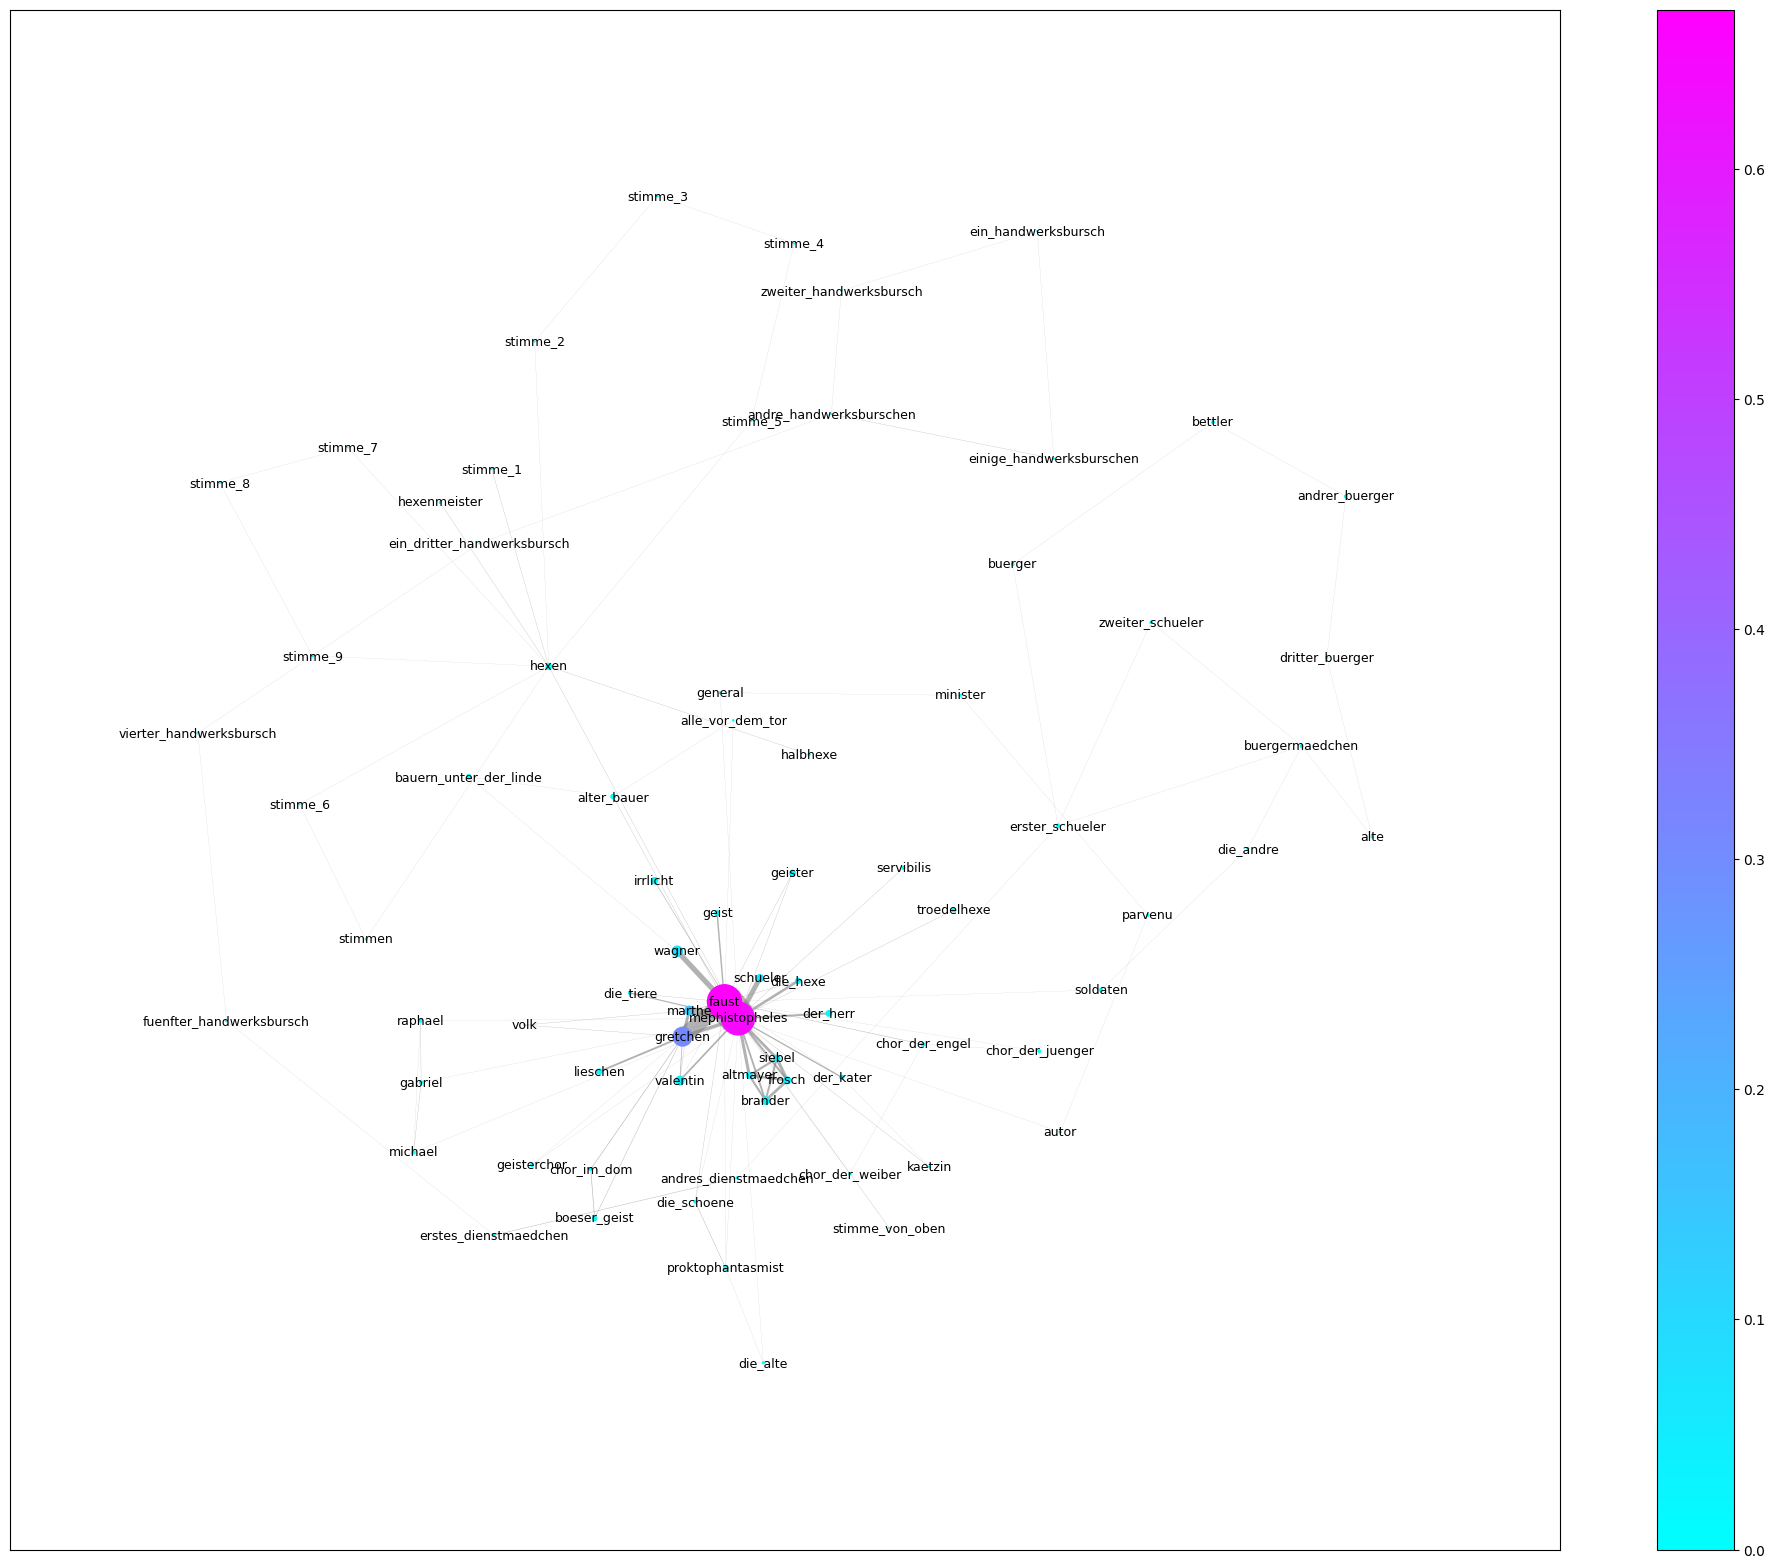

In [48]:
components = nx.connected_components(E)
largest_comp = max(components, key=len)
F = E.subgraph(largest_comp)

plt.rcParams["figure.figsize"]=25,20
        
pos = nx.spring_layout(F, k=.2)
        
ne = nx.draw_networkx_nodes(F,
                            pos=pos,
                            node_color=list(nx.get_node_attributes(F, 'eigenvector_centrality_weighted').values()), # Knotenattribut, das zur Bestimmung der Farben verwendet werden soll
                            cmap=plt.cm.cool, # colormap, siehe https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
                            node_size=list(nx.get_node_attributes(F, 'text_weight').values())
                           )
nx.draw_networkx_labels(F,
                        pos=pos,
                        font_size=9,
                        font_color="black"
                       )
nx.draw_networkx_edges(F,
                       pos=pos,
                       width=list(nx.get_edge_attributes(F, 'weight').values()),
                       edge_color="grey",
                       alpha=.6
                      )
plt.margins(0.1)
plt.colorbar(ne) # Farbbalken als Legende hinzufügen (dazu muss auf den gezeichneten Teil mit cmap zugegriffen werden können)
plt.show()

## Cliquen
Eine Clique (oder vollständiger Teilgraph) ist eine Gruppe von Knoten, die alle untereinander verbunden sind (bei uns: Gruppen von Charakteren, in denen jeder Charakter mit jedem anderen Charakter aus der Gruppe interagiert). In der Netzwerkanalyse können diese besonders interessant sein, v.a. die sog maximalen Cliquen, also Cliquen, die sich nicht um weitere Knoten erweitern lassen (ohne dass dadurch der Cliquenstatus verlorengeht). [Cliquen zu finden, ist ein NP-vollständiges Problem](https://en.wikipedia.org/wiki/Clique_problem), kann also bei größeren Graphen lange dauern (exponentielle Laufzeit).

`find_cliques()` liefert uns alle maximalen Cliquen in einem Graphen. Da eine maximale Clique auch aus nur zwei Knoten bestehen kann (und eine solche Clique nicht besonders interessant sein dürfte ...), bietet es sich wahrscheinlich an, erst einmal zu gucken, was überhaupt die größte Cliquengröße ist:

In [49]:
max([len(clique) for clique in nx.find_cliques(E)])

5

Ebenso ist es wahrscheinlich sinnvoll, sich nur maximale Cliquen einer bestimmten Mindestgröße näher anzusehen:

In [50]:
for c in nx.find_cliques(E):
    if len(c) > 3:
        print(c)

['mephistopheles', 'michael', 'gabriel', 'raphael']
['mephistopheles', 'faust', 'die_schoene', 'proktophantasmist']
['mephistopheles', 'faust', 'valentin', 'marthe', 'gretchen']
['mephistopheles', 'altmayer', 'siebel', 'frosch', 'brander']
